## Connect to Comet

In [43]:
!pip install comet_ml

^C
ERROR: Operation cancelled by user


In [44]:
COMET_DISABLE_AUTO_LOGGING = 1

In [45]:
import comet_ml
from comet_ml import Experiment

### UNCOMMENT ###
#Setting up the API KEY
experiment = Experiment(api_key= 'xHRiEsQ8ADZrOR6bO0WpE2aWW',project_name="classification-team-1-jhb",workspace="crtshabangu")

ImportError: You must import Comet before these modules: sklearn

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#visualization
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

In [88]:
train_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/train.csv')
test_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/test.csv')
genome_scores_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/genome_scores.csv')
genome_tags_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/genome_tags.csv')
imdb_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/imdb_data.csv')
movies_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/movies.csv')
tags_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/tags.csv')
links_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/links.csv')

submission_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/sample_submission.csv')

In [89]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [90]:
train_df = train_df.sample(10000)

In [91]:
train_df.shape

(10000, 4)

Missing values

In [92]:
train_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Duplicates

In [93]:
duplicates = train_df.duplicated(["movieId","userId", "rating"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


Let's see some movie titles

In [94]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [95]:
movies_info_df = pd.merge(train_df,movies_df, on='movieId')
movies_info_df.head()

,userId,movieId,rating,timestamp,title,genres
0,149580,3114,5.0,999615040,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
1,70268,3114,5.0,952826227,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2,37438,3114,4.0,975070726,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3,124686,3114,4.0,1403029446,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
4,84516,3114,4.5,1175719798,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy


In [96]:
movies_info_df.shape

(10000, 6)

### Utility Sparse Matrix

We will construct the matrix using `pivot table` function.

In [97]:
idx = ['userId']
col = ['title']
val = 'rating'
sparse_matrix = movies_info_df.pivot_table(idx,col,val)

In [98]:
sparse_matrix.shape


(3719, 10)

### Visualize Sparse matrix

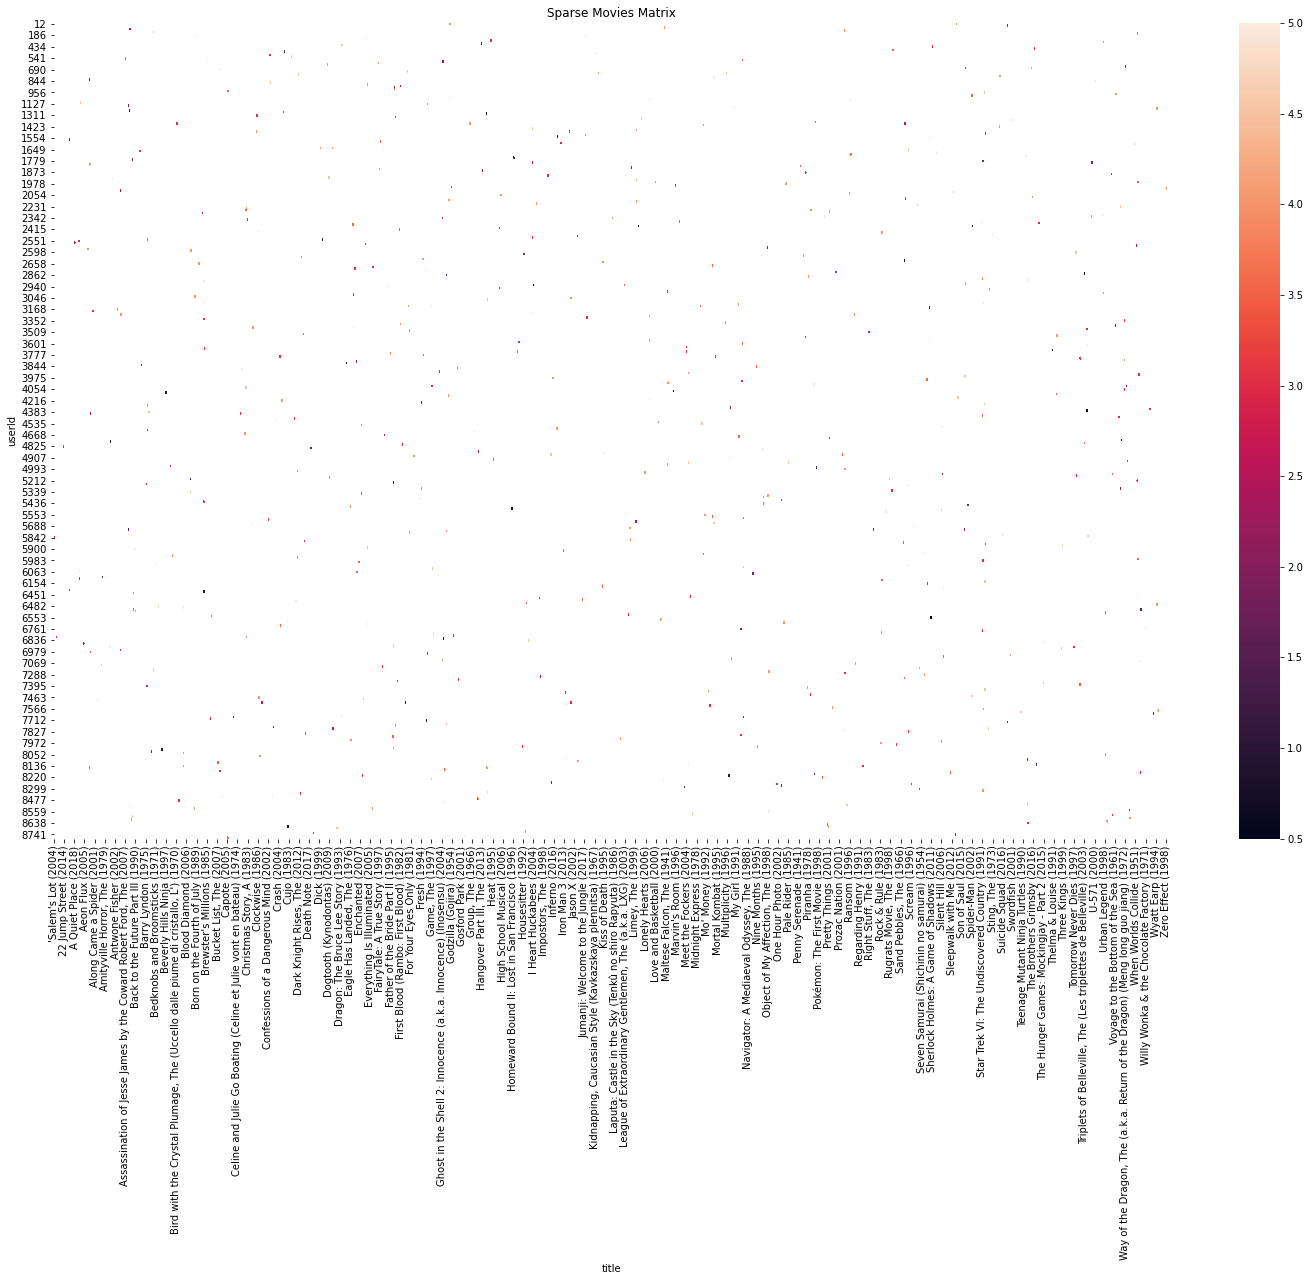

In [99]:
sparse_matrix= movies_info_df.pivot_table(index=['userId'], 
                                            columns=['title'],
                                            values='rating')
fig, ax = plt.subplots(figsize=(25,15))
_ = sns.heatmap(sparse_matrix[:500], annot=False, ax=ax).set_title('Sparse Movies Matrix')

White space indicates no ratings. That means a `user` did not give a rating for a particular movie.

Process data for similarity computation :
*  normalising each user's set of ratings. Recall that the formula for normalizing is x-mean/max(x)-min(x).
*  filling in Nan values with 0.
*  transpose matrix for easier indexing.
*  drop users with no ratings.
*  store the matrix in a sparse representation to save memory.


In [100]:
#Normalise a user's rating:
def normalizer():
    norm_rating = sparse_matrix.apply(lambda x : (x- np.mean(x))/(max(x)-min(x)) , axis = 1)
    return norm_rating


In [101]:
normalized_matrix = normalizer()

In [102]:
#fill null values with 0.
normalized_matrix.fillna(0,inplace=True)

In [103]:
#Transpose matrix
normalized_matrix = normalized_matrix.T

In [104]:
#Drop users with no ratings
new_matrix = normalized_matrix.loc[:, (normalized_matrix != 0).any(axis=0)]

Save matrix in scipy's sparse matrix format

In [105]:
new_matrix_sparse = sp.sparse.csr_matrix(new_matrix.values)

In [106]:
new_matrix_sparse

<3719x1 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

### Similarity between users based on ratings

We compute the similarity matrix using the cosine similarity metric.

In [107]:
user_similarity = cosine_similarity(new_matrix_sparse.T)

In [108]:
# Save the matrix as a dataframe to allow for easier indexing  
user_similarity_df = pd.DataFrame(user_similarity, 
                           index = new_matrix.columns, 
                           columns = new_matrix.columns)

# Review a small portion of the constructed similartiy matrix  
user_similarity_df.head()

userId,144475
userId,
144475,1.0


In [109]:
user_similarity_df.columns

Int64Index([144475], dtype='int64', name='userId')

In [110]:
 movies_info_df.groupby('title')['rating'].mean().sort_values(ascending=False).index

Index(['Cars (2006)', 'Jean de Florette (1986)', 'Spitfire Grill, The (1996)',
       'Haunting, The (1963)', 'Flight of the Phoenix, The (1965)',
       'Match Point (2005)', 'Haunted World of Edward D. Wood Jr., The (1996)',
       'Clockwise (1986)', 'Hate (Haine, La) (1995)',
       'Celine and Julie Go Boating (Celine et Julie vont en bateau) (1974)',
       ...
       'Step Up (2006)', 'Mother's Day (2016)', 'DNA (1997)',
       'The Zookeeper's Wife (2017)',
       'Adventures of Ford Fairlane, The (1990)', 'Return to Oz (1985)',
       'Triangle (2009)', 'Conan the Barbarian (2011)', 'Hulk (2003)',
       'Night of the Living Dead: Darkest Dawn (2015)'],
      dtype='object', name='title', length=3719)

In [111]:
user_similarity_df.head()

userId,144475
userId,
144475,1.0


In [112]:


for i in user_similarity_df.index:
    #sim = user_similarity_df.index[0]
    ids = i

    
    

In [113]:
def top_N_recommend(user,N,u):
    user_cols = user_similarity_df.columns
    #get the average of the ratings 
    avg_ratings = movies_info_df.groupby('title')['rating'].mean()
    #get only the index, let's get 50 movie titles and make into a list
    avg_ratings = avg_ratings.index[:N].to_list() #Top 50 most popular movies.
    
    #if user is not in the user_cols, return a list of Top 50 most popular movies.
    if user not in user_cols:
        return avg_ratings
    #Most similar movies to a new user.
    similar_users = user_cols[user].sort_values(ascending=False).index[1:u+1]
    movies_liked=[] #list containing hihgly rated movies extracted from u users.
    users_highly_rated={} #dict of k users for highly rated items.
    
    for m in similar_users:
        #highest rating given by current user 
        maximum_rating = new_matrix.loc[:,m].max()
        #save names of movies maximally rated by he current user
        x = new_matrix[new_matrix.loc[:,m]== maximum_rating].index.tolist()
        movies_liked.append(x)
    
    #Each user's favourite movies and keep record of which ones are popular
    for movie in range(len(movies_liked)):
        for moviee in movies_liked[movie]: 
            if moviee in users_highly_rated:
                users_highly_rated[moviee] += 1
            else:
                users_highly_rated[moviee] = 1
       
      # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(users_highly_rated.items(), key=operator.itemgetter(1), reverse=True)[:N]
    Top_N = [x[0] for x in sorted_list]
    return Top_N   
    
    
    

In [114]:
top_N_recommend(4144,20,40,)

["'Salem's Lot (2004)",
 "'Til There Was You (1997)",
 "'burbs, The (1989)",
 '(500) Days of Summer (2009)',
 '...And Justice for All (1979)',
 '10 (1979)',
 '10 Cloverfield Lane (2016)',
 '10 Things I Hate About You (1999)',
 '10,000 BC (2008)',
 '101 Dalmatians (1996)',
 '101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 '12 Angry Men (1957)',
 '12 Angry Men (1997)',
 '12 Years a Slave (2013)',
 '127 Hours (2010)',
 '13 Assassins (Jûsan-nin no shikaku) (2010)',
 '13 Demons (2016)',
 '13 Going on 30 (2004)',
 '13th Warrior, The (1999)',
 '1408 (2007)']

In [115]:
def collab_generate_rating_estimate(title, user, k=20, threshold=0.0):
    # Gather the k users which are most similar to the reference user 
    sim_users = user_similarity_df.sort_values(by=user, ascending=False).index[1:k+1]
    # Store the corresponding user's similarity values 
    user_values = user_similarity_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:k+1]
    rating_list = [] # <-- List of k user's ratings for the reference item
    weight_list = [] # <-- List of k user's similarities to the reference user
    
    # Create a weighted sum for each of the k users who have rated the 
    # reference item (book).
    for sim_idx, user_id in enumerate(sim_users):
        # User's rating of the item
        rating = sparse_matrix.loc[user_id,title]
        # User's similarity to the reference user 
        similarity = user_values[sim_idx]
        # Skip the user if they have not rated the item, or are too dissimilar to 
        # the reference user
        if (np.isnan(rating)) or (similarity < threshold):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    try:
        # Return the weighted sum as the predicted rating for the reference item
        predicted_rating = sum(rating_list)/sum(weight_list) 
    except ZeroDivisionError:
        # If no ratings for the reference item can be collected, return the average 
        # rating given by all users for the item.  
        predicted_rating = np.mean(sparse_matrix[title])
    return predicted_rating

In [116]:
df=movies_info_df[movies_info_df['userId'] == ids][:][['title','rating']].sort_values(by='rating', ascending=False)[:10]

In [117]:
df

,title,rating
9204,'Salem's Lot (2004),3.0
5795,"Amityville Horror, The (2005)",2.5
9538,Mother's Day (1980),1.5
9968,Flight of the Intruder (1991),1.5
9724,Obsessed (2009),1.0


In [118]:
df = df.rename_axis("userId")
df

,title,rating
userId,,
9204,'Salem's Lot (2004),3.0
5795,"Amityville Horror, The (2005)",2.5
9538,Mother's Day (1980),1.5
9968,Flight of the Intruder (1991),1.5
9724,Obsessed (2009),1.0


In [119]:
for i in user_similarity_df.index:
    ids=i
    print(ids)
    

144475


In [120]:
cols = df['title']
actual = []
predicted = []
for movie in cols:
    #actual_rating = movies_info_df[(movies_info_df['userId'] == ids) & (movies_info_df['title'] == title)]['rating'].values[0]
    pred_rating = collab_generate_rating_estimate(title = movie ,user=ids)
    #actual.append(actual_rating)
    predicted.append(round(pred_rating,1))
print (actual)
print (predicted)
    

[]
[3.0, 2.8, 1.5, 1.5, 2.0]


In [121]:
id_s = movies_info_df['userId'].to_list()
m_id = movies_info_df['movieId'].to_list()
reviewed = list(zip(predicted,id_s,m_id))
reviewed

[(3.0, 149580, 3114),
 (2.8, 70268, 3114),
 (1.5, 37438, 3114),
 (1.5, 124686, 3114),
 (2.0, 84516, 3114)]

In [122]:
rated_ratings = pd.DataFrame(reviewed,columns = ['rating','userId','movieId'])

rated_ratings.head()

,rating,userId,movieId
0,3.0,149580,3114
1,2.8,70268,3114
2,1.5,37438,3114
3,1.5,124686,3114
4,2.0,84516,3114


In [ ]:
id_s = movies_info_df['userId'].to_list()
m_id = movies_info_df['movieId'].to_list()

for i in id_s:
    for k in m_id:
        new = str(i) + '_' + str(k)

        print(new)


149580_3114
149580_3114
149580_3114
149580_3114
149580_3114
149580_3114
149580_3114
149580_22
149580_22
149580_22
149580_22
149580_22
149580_22
149580_122904
149580_122904
149580_122904
149580_122904
149580_122904
149580_122904
149580_122904
149580_122904
149580_122904
149580_208
149580_208
149580_208
149580_208
149580_208
149580_208
149580_208
149580_208
149580_208
149580_208
149580_208
149580_208
149580_208
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_33794
149580_44555
149580_44555
149580_44555
149580_44555
149580_44555
149580_44555
149580_44555
149580_44555
149580_44555
149580_44555
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_457
149580_6222
149580_6222
149580_6222
149580_89343
149580_112804
149

149580_2054
149580_523
149580_523
149580_1573
149580_1573
149580_1573
149580_1573
149580_1573
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_4993
149580_3362
149580_3362
149580_3362
149580_3362
149580_3362
149580_4007
149580_4007
149580_4007
149580_4007
149580_2454
149580_2454
149580_2454
149580_2454
149580_2021
149580_2021
149580_3702
149580_3702
149580_3702
149580_3702
149580_3702
149580_4368
149580_4368
149580_38061
149580_38061
149580_5816
149580_5816
149580_5816
149580_5816
149580_5816
149580_5816
149580_5816
149580_5816
149580_4643
149580_4643
149580_4643
149580_4643
149580_4643
149580_4643
149580_4643
149580_147
149580_147
149580_147
149580_147
149580_1228
149580_1228
149580_1228
149580_69640
149580_69640
149580_69640
149580_44761
149580_6377
149580_6377
1495

149580_69122
149580_54001
149580_54001
149580_54001
149580_54001
149580_54001
149580_159121
149580_147338
149580_2986
149580_2986
149580_161131
149580_161131
149580_4700
149580_4700
149580_1022
149580_1022
149580_1022
149580_1022
149580_1022
149580_1022
149580_1022
149580_1022
149580_72998
149580_72998
149580_72998
149580_72998
149580_72998
149580_72998
149580_72998
149580_72998
149580_72998
149580_72998
149580_3952
149580_84772
149580_84772
149580_84772
149580_84772
149580_65642
149580_65642
149580_1219
149580_1219
149580_1219
149580_1219
149580_1219
149580_1219
149580_1219
149580_1219
149580_1219
149580_77561
149580_77561
149580_77561
149580_77561
149580_77561
149580_77561
149580_60069
149580_60069
149580_60069
149580_60069
149580_60069
149580_60069
149580_60069
149580_60069
149580_60069
149580_60069
149580_2052
149580_166528
149580_166528
149580_166528
149580_2572
149580_2572
149580_2572
149580_2572
149580_2572
149580_2572
149580_1253
149580_1253
149580_1253
149580_1253
149580_1747


149580_37382
149580_5377
149580_5377
149580_5377
149580_5377
149580_5377
149580_61075
149580_61075
149580_2600
149580_2600
149580_2600
149580_1238
149580_1238
149580_2312
149580_2312
149580_923
149580_923
149580_923
149580_923
149580_923
149580_923
149580_923
149580_923
149580_27373
149580_1175
149580_197711
149580_2096
149580_2096
149580_5444
149580_5444
149580_1883
149580_3006
149580_3006
149580_3006
149580_3006
149580_3006
149580_87232
149580_87232
149580_87232
149580_87232
149580_87232
149580_1963
149580_1963
149580_2126
149580_2126
149580_2126
149580_1094
149580_1094
149580_1094
149580_105844
149580_105844
149580_105844
149580_105844
149580_105844
149580_5128
149580_5128
149580_116951
149580_80906
149580_80906
149580_3178
149580_3178
149580_3178
149580_3178
149580_3617
149580_3617
149580_3617
149580_882
149580_1609
149580_3471
149580_3471
149580_3471
149580_3471
149580_3471
149580_3471
149580_2423
149580_162864
149580_6722
149580_5291
149580_122900
149580_122900
149580_122900
1495

149580_101258
149580_8984
149580_8984
149580_2524
149580_2881
149580_2881
149580_7616
149580_59985
149580_3328
149580_3328
149580_229
149580_25996
149580_115713
149580_115713
149580_115713
149580_314
149580_314
149580_2401
149580_2160
149580_8640
149580_8640
149580_8640
149580_7896
149580_3713
149580_3713
149580_543
149580_543
149580_543
149580_543
149580_543
149580_2018
149580_2018
149580_2018
149580_2018
149580_36535
149580_36535
149580_101864
149580_101864
149580_3668
149580_6755
149580_6755
149580_168250
149580_168250
149580_2966
149580_96079
149580_96079
149580_148626
149580_148626
149580_148626
149580_148626
149580_299
149580_709
149580_168366
149580_168366
149580_168366
149580_66097
149580_88744
149580_88744
149580_88744
149580_88744
149580_88744
149580_7387
149580_7387
149580_2862
149580_304
149580_3791
149580_3791
149580_1147
149580_2288
149580_2288
149580_96811
149580_1858
149580_82934
149580_7155
149580_3462
149580_3462
149580_2313
149580_2313
149580_2313
149580_48738
149580

149580_4270
149580_456
149580_6385
149580_8995
149580_6880
149580_51084
149580_72737
149580_1399
149580_2079
149580_76175
149580_5339
149580_31698
149580_2879
149580_157
149580_3325
149580_8808
149580_2841
149580_156585
149580_93142
149580_870
149580_6518
149580_60514
149580_2173
149580_26160
149580_109483
149580_108945
149580_36276
149580_91104
149580_2318
149580_6123
149580_14
149580_7569
149580_479
149580_971
149580_46335
149580_421
149580_140773
149580_138208
149580_3929
149580_166
149580_154892
149580_42900
149580_55269
149580_65882
149580_86892
149580_177985
149580_89039
149580_140247
149580_7914
149580_6533
149580_637
149580_2702
70268_3114
70268_3114
70268_3114
70268_3114
70268_3114
70268_3114
70268_3114
70268_22
70268_22
70268_22
70268_22
70268_22
70268_22
70268_122904
70268_122904
70268_122904
70268_122904
70268_122904
70268_122904
70268_122904
70268_122904
70268_122904
70268_208
70268_208
70268_208
70268_208
70268_208
70268_208
70268_208
70268_208
70268_208
70268_208
70268_2

70268_2054
70268_2054
70268_2054
70268_2054
70268_523
70268_523
70268_1573
70268_1573
70268_1573
70268_1573
70268_1573
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_4993
70268_3362
70268_3362
70268_3362
70268_3362
70268_3362
70268_4007
70268_4007
70268_4007
70268_4007
70268_2454
70268_2454
70268_2454
70268_2454
70268_2021
70268_2021
70268_3702
70268_3702
70268_3702
70268_3702
70268_3702
70268_4368
70268_4368
70268_38061
70268_38061
70268_5816
70268_5816
70268_5816
70268_5816
70268_5816
70268_5816
70268_5816
70268_5816
70268_4643
70268_4643
70268_4643
70268_4643
70268_4643
70268_4643
70268_4643
70268_147
70268_147
70268_147
70268_147
70268_1228
70268_1228
70268_1228
70268_69640
70268_69640
70268_69640
70268_44761
70268_6377
70268_6377
70268_6377
70268_6377
70268_6377
70268_6377
70268_5015

70268_69122
70268_69122
70268_69122
70268_54001
70268_54001
70268_54001
70268_54001
70268_54001
70268_159121
70268_147338
70268_2986
70268_2986
70268_161131
70268_161131
70268_4700
70268_4700
70268_1022
70268_1022
70268_1022
70268_1022
70268_1022
70268_1022
70268_1022
70268_1022
70268_72998
70268_72998
70268_72998
70268_72998
70268_72998
70268_72998
70268_72998
70268_72998
70268_72998
70268_72998
70268_3952
70268_84772
70268_84772
70268_84772
70268_84772
70268_65642
70268_65642
70268_1219
70268_1219
70268_1219
70268_1219
70268_1219
70268_1219
70268_1219
70268_1219
70268_1219
70268_77561
70268_77561
70268_77561
70268_77561
70268_77561
70268_77561
70268_60069
70268_60069
70268_60069
70268_60069
70268_60069
70268_60069
70268_60069
70268_60069
70268_60069
70268_60069
70268_2052
70268_166528
70268_166528
70268_166528
70268_2572
70268_2572
70268_2572
70268_2572
70268_2572
70268_2572
70268_1253
70268_1253
70268_1253
70268_1253
70268_1747
70268_1747
70268_1747
70268_1747
70268_1747
70268_1747


70268_4102
70268_4102
70268_55
70268_37382
70268_5377
70268_5377
70268_5377
70268_5377
70268_5377
70268_61075
70268_61075
70268_2600
70268_2600
70268_2600
70268_1238
70268_1238
70268_2312
70268_2312
70268_923
70268_923
70268_923
70268_923
70268_923
70268_923
70268_923
70268_923
70268_27373
70268_1175
70268_197711
70268_2096
70268_2096
70268_5444
70268_5444
70268_1883
70268_3006
70268_3006
70268_3006
70268_3006
70268_3006
70268_87232
70268_87232
70268_87232
70268_87232
70268_87232
70268_1963
70268_1963
70268_2126
70268_2126
70268_2126
70268_1094
70268_1094
70268_1094
70268_105844
70268_105844
70268_105844
70268_105844
70268_105844
70268_5128
70268_5128
70268_116951
70268_80906
70268_80906
70268_3178
70268_3178
70268_3178
70268_3178
70268_3617
70268_3617
70268_3617
70268_882
70268_1609
70268_3471
70268_3471
70268_3471
70268_3471
70268_3471
70268_3471
70268_2423
70268_162864
70268_6722
70268_5291
70268_122900
70268_122900
70268_122900
70268_2006
70268_2006
70268_2006
70268_2006
70268_2006

70268_1227
70268_107827
70268_101258
70268_8984
70268_8984
70268_2524
70268_2881
70268_2881
70268_7616
70268_59985
70268_3328
70268_3328
70268_229
70268_25996
70268_115713
70268_115713
70268_115713
70268_314
70268_314
70268_2401
70268_2160
70268_8640
70268_8640
70268_8640
70268_7896
70268_3713
70268_3713
70268_543
70268_543
70268_543
70268_543
70268_543
70268_2018
70268_2018
70268_2018
70268_2018
70268_36535
70268_36535
70268_101864
70268_101864
70268_3668
70268_6755
70268_6755
70268_168250
70268_168250
70268_2966
70268_96079
70268_96079
70268_148626
70268_148626
70268_148626
70268_148626
70268_299
70268_709
70268_168366
70268_168366
70268_168366
70268_66097
70268_88744
70268_88744
70268_88744
70268_88744
70268_88744
70268_7387
70268_7387
70268_2862
70268_304
70268_3791
70268_3791
70268_1147
70268_2288
70268_2288
70268_96811
70268_1858
70268_82934
70268_7155
70268_3462
70268_3462
70268_2313
70268_2313
70268_2313
70268_48738
70268_48738
70268_48738
70268_413
70268_413
70268_413
70268_41

70268_52606
70268_111659
70268_5336
70268_808
70268_27627
70268_100302
70268_4270
70268_456
70268_6385
70268_8995
70268_6880
70268_51084
70268_72737
70268_1399
70268_2079
70268_76175
70268_5339
70268_31698
70268_2879
70268_157
70268_3325
70268_8808
70268_2841
70268_156585
70268_93142
70268_870
70268_6518
70268_60514
70268_2173
70268_26160
70268_109483
70268_108945
70268_36276
70268_91104
70268_2318
70268_6123
70268_14
70268_7569
70268_479
70268_971
70268_46335
70268_421
70268_140773
70268_138208
70268_3929
70268_166
70268_154892
70268_42900
70268_55269
70268_65882
70268_86892
70268_177985
70268_89039
70268_140247
70268_7914
70268_6533
70268_637
70268_2702
37438_3114
37438_3114
37438_3114
37438_3114
37438_3114
37438_3114
37438_3114
37438_22
37438_22
37438_22
37438_22
37438_22
37438_22
37438_122904
37438_122904
37438_122904
37438_122904
37438_122904
37438_122904
37438_122904
37438_122904
37438_122904
37438_208
37438_208
37438_208
37438_208
37438_208
37438_208
37438_208
37438_208
37438_20

37438_1097
37438_1097
37438_1097
37438_1097
37438_1097
37438_1097
37438_1097
37438_1097
37438_1097
37438_1097
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_5349
37438_112138
37438_112138
37438_3773
37438_106072
37438_3420
37438_3409
37438_3409
37438_3409
37438_3409
37438_3409
37438_2023
37438_2023
37438_2023
37438_2023
37438_2023
37438_2023
37438_2700
37438_2700
37438_2700
37438_2700
37438_2700
37438_2700
37438_2700
37438_2700
37438_2700
37438_2700
37438_2700
37438_2700
37438_1872
37438_1872
37438_152081
37438_152081
37438_152081
37438_3
37438_3
37438_3
37438_3
37438_3
37438_3
37438_3
37438_3418
37438_3418
37438_3418
37438_3418
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
37438_590
3

37438_1721
37438_1721
37438_3153
37438_3623
37438_3623
37438_3623
37438_1923
37438_1923
37438_1923
37438_1923
37438_1923
37438_1923
37438_1923
37438_1923
37438_1923
37438_1923
37438_1923
37438_6218
37438_6218
37438_6218
37438_6218
37438_6218
37438_6218
37438_837
37438_837
37438_837
37438_837
37438_1295
37438_1295
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_589
37438_44840
37438_44840
37438_8622
37438_8622
37438_8622
37438_8622
37438_8622
37438_8622
37438_8622
37438_8622
37438_606
37438_4239
37438_4239
37438_4239
37438_1278
37438_1278
37438_1278
37438_1278
37438_1278
37438_1278
37438_1278
37438_1278
37438_1278
37438_1278
37438_1278
37438_2531
37438_2531
37438_95105
37438_71282
37438_71282
37438_71282
37438_71282
37438_8665
37438_8665
37438_8665
37438_8665
37438_8665
37438_8665
37438_5878
37438_5878
37438_5878
37438_2328
37438_2328
37438_59315
37438_59315
37438_59315
37438_5931

37438_587
37438_587
37438_587
37438_587
37438_587
37438_587
37438_587
37438_587
37438_587
37438_587
37438_587
37438_587
37438_781
37438_781
37438_781
37438_3704
37438_3704
37438_3704
37438_7030
37438_3868
37438_3868
37438_3868
37438_3868
37438_3868
37438_3868
37438_3868
37438_3868
37438_3868
37438_5618
37438_5618
37438_5618
37438_5618
37438_5618
37438_5618
37438_5618
37438_5618
37438_5618
37438_2683
37438_2683
37438_2683
37438_2683
37438_2683
37438_2683
37438_2683
37438_2683
37438_2683
37438_5712
37438_44849
37438_44849
37438_6548
37438_6548
37438_6548
37438_6548
37438_6548
37438_6548
37438_31364
37438_2379
37438_2379
37438_1731
37438_11
37438_11
37438_11
37438_11
37438_2763
37438_2763
37438_90746
37438_90746
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_3147
37438_6003
37438_6852
37438_1083
37438_1083
37438_8531
37438_8531
37438_8531
37438_4613
37438_4613
37438_

37438_5903
37438_5903
37438_5903
37438_7325
37438_41
37438_3468
37438_3468
37438_5002
37438_2539
37438_2539
37438_2539
37438_2539
37438_2539
37438_2539
37438_2539
37438_2539
37438_8781
37438_138104
37438_26003
37438_26003
37438_2367
37438_73344
37438_73344
37438_3968
37438_4874
37438_4874
37438_4874
37438_1845
37438_64167
37438_5278
37438_116887
37438_4149
37438_86
37438_86
37438_1217
37438_2641
37438_2641
37438_116977
37438_58123
37438_7088
37438_55247
37438_55247
37438_55247
37438_98056
37438_72226
37438_72226
37438_1245
37438_1245
37438_1245
37438_5813
37438_115122
37438_115122
37438_166369
37438_58078
37438_81834
37438_81834
37438_81834
37438_81834
37438_81834
37438_81834
37438_81834
37438_81834
37438_81834
37438_81834
37438_81834
37438_81834
37438_81834
37438_238
37438_7137
37438_1545
37438_3998
37438_112552
37438_112552
37438_112552
37438_112552
37438_2034
37438_378
37438_378
37438_33004
37438_33004
37438_33004
37438_7766
37438_7766
37438_7766
37438_127164
37438_2554
37438_33437


37438_3840
37438_27706
37438_27706
37438_27706
37438_27706
37438_2718
37438_2718
37438_48696
37438_48696
37438_4333
37438_7480
37438_2068
37438_1966
37438_1554
37438_7229
37438_182715
37438_5294
37438_4571
37438_4571
37438_4571
37438_113345
37438_81257
37438_100487
37438_2505
37438_942
37438_5049
37438_5049
37438_258
37438_206
37438_45440
37438_59615
37438_5110
37438_7089
37438_3835
37438_951
37438_120635
37438_90600
37438_6991
37438_92420
37438_45186
37438_45186
37438_30793
37438_30793
37438_30793
37438_2391
37438_53519
37438_44665
37438_44665
37438_72131
37438_806
37438_8366
37438_8366
37438_2320
37438_107625
37438_2249
37438_8228
37438_8228
37438_27338
37438_40966
37438_8337
37438_2635
37438_3435
37438_71304
37438_81535
37438_4788
37438_937
37438_6932
37438_70293
37438_2140
37438_5512
37438_69436
37438_3216
37438_4844
37438_4844
37438_176567
37438_160559
37438_144766
37438_207
37438_4771
37438_48231
37438_50003
37438_69951
37438_69951
37438_6862
37438_6198
37438_72731
37438_1586
374

124686_25
124686_25
124686_25
124686_25
124686_25
124686_25
124686_25
124686_25
124686_25
124686_25
124686_25
124686_25
124686_25
124686_25
124686_1729
124686_1729
124686_1729
124686_1729
124686_1729
124686_1729
124686_1729
124686_1729
124686_1729
124686_5959
124686_5959
124686_45517
124686_2860
124686_2860
124686_85
124686_85
124686_139978
124686_351
124686_351
124686_351
124686_60832
124686_911
124686_911
124686_911
124686_8581
124686_933
124686_933
124686_933
124686_8368
124686_8368
124686_8368
124686_8368
124686_8368
124686_8368
124686_8368
124686_8368
124686_8368
124686_8368
124686_8368
124686_5628
124686_3100
124686_3100
124686_3100
124686_3100
124686_3100
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_2628
124686_6527
124686_2599
124686_2599
124686_2599
124686_2599
124686_2599
124686_2599
124686_51255
124686_51255
124686_51255
124686_51255
1

124686_500
124686_500
124686_500
124686_500
124686_500
124686_500
124686_500
124686_500
124686_1189
124686_76251
124686_76251
124686_76251
124686_76251
124686_76251
124686_1962
124686_1962
124686_1962
124686_1962
124686_1962
124686_934
124686_934
124686_934
124686_934
124686_934
124686_934
124686_509
124686_509
124686_509
124686_509
124686_509
124686_509
124686_509
124686_509
124686_509
124686_509
124686_509
124686_79091
124686_79091
124686_79091
124686_79091
124686_79091
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_5445
124686_64620
124686_64620
124686_64620
124686_64620
124686_4428
124686_6534
124686_7701
124686_170729
124686_1982
124686_2118
124686_2118
124686_2118
124686_2118
124686_2118
124686_2118
124686_1120
124686_1120
124686_1120
124686_1120
124686_1120
124686_142503
124686_881
124686_8957


124686_3087
124686_3087
124686_3087
124686_3087
124686_3087
124686_2866
124686_2866
124686_462
124686_550
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_316
124686_3984
124686_3984
124686_3083
124686_3083
124686_2709
124686_1286
124686_47491
124686_3948
124686_3948
124686_3948
124686_3948
124686_5220
124686_6252
124686_2243
124686_2243
124686_2243
124686_2243
124686_74789
124686_74789
124686_74789
124686_3947
124686_61697
124686_6763
124686_647
124686_647
124686_647
124686_5244
124686_5244
124686_169984
124686_1344
124686_1344
124686_40629
124686_40629
124686_40629
124686_2329
124686_2329
124686_2329
124686_2329
124686_2329
124686_2329
124686_2329
124686_2329
124686_2329
124686_2329
124686_2329
124686_2329
124686_2329
124686_435
124686_435
124686_435
124686_435
124686_94777
124686_94777
124686_94777
124686_94777
124686_1242
124686_1242
124686_1242
124686_8464
124686_8464
12

124686_2348
124686_2348
124686_2348
124686_55278
124686_110127
124686_2918
124686_2918
124686_2918
124686_2918
124686_2918
124686_2918
124686_2918
124686_2918
124686_2918
124686_2918
124686_2918
124686_130686
124686_2560
124686_113374
124686_130520
124686_203
124686_203
124686_203
124686_203
124686_203
124686_203
124686_4488
124686_81845
124686_81845
124686_81845
124686_81845
124686_81845
124686_81845
124686_81845
124686_81845
124686_81845
124686_4359
124686_4359
124686_86320
124686_48774
124686_48774
124686_48774
124686_48774
124686_48774
124686_48774
124686_5329
124686_540
124686_273
124686_273
124686_157959
124686_996
124686_996
124686_4210
124686_53769
124686_27831
124686_27831
124686_2001
124686_2001
124686_2001
124686_79868
124686_6936
124686_6936
124686_6936
124686_6936
124686_116313
124686_46578
124686_46578
124686_46578
124686_46578
124686_46578
124686_46578
124686_46578
124686_46578
124686_5825
124686_491
124686_491
124686_491
124686_34536
124686_195159
124686_195159
124686_1

124686_2381
124686_2131
124686_3615
124686_1515
124686_1515
124686_8336
124686_2420
124686_2420
124686_96655
124686_73168
124686_1690
124686_112897
124686_1104
124686_45666
124686_99996
124686_67408
124686_6325
124686_5955
124686_1007
124686_29
124686_29
124686_29
124686_78209
124686_73211
124686_175397
124686_950
124686_950
124686_950
124686_3555
124686_3555
124686_3555
124686_135137
124686_135532
124686_1283
124686_1283
124686_2857
124686_2857
124686_120799
124686_120799
124686_4030
124686_3024
124686_1541
124686_74668
124686_5017
124686_313
124686_731
124686_4848
124686_4848
124686_4848
124686_6062
124686_2452
124686_6708
124686_4002
124686_3598
124686_80860
124686_86911
124686_86911
124686_103384
124686_1187
124686_101025
124686_181555
124686_81564
124686_4492
124686_3738
124686_30745
124686_85022
124686_85022
124686_6264
124686_6264
124686_6264
124686_2142
124686_2142
124686_25771
124686_3327
124686_54648
124686_6614
124686_8713
124686_27689
124686_27873
124686_155820
124686_7367


84516_7386
84516_7386
84516_58559
84516_58559
84516_58559
84516_58559
84516_58559
84516_58559
84516_58559
84516_58559
84516_58559
84516_58559
84516_58559
84516_58559
84516_719
84516_719
84516_719
84516_719
84516_719
84516_719
84516_261
84516_261
84516_261
84516_261
84516_261
84516_261
84516_261
84516_33679
84516_33679
84516_33679
84516_653
84516_653
84516_653
84516_653
84516_653
84516_653
84516_144172
84516_1221
84516_1221
84516_1221
84516_1221
84516_1221
84516_1221
84516_1221
84516_1221
84516_1221
84516_1221
84516_1221
84516_1221
84516_1221
84516_903
84516_903
84516_903
84516_903
84516_903
84516_903
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_1
84516_52104
84516_1101
84516_1101
84516_1101
84516_1101
84516_1101
84516_1101
84516_1101
84516_1101
84516_1101
84516_1101
84516_1101
84516_1527
84516_1527
84516_1527
84516_1527
84516_1527
84516_1527
84516_152

84516_48780
84516_48780
84516_6
84516_6
84516_6
84516_6
84516_6
84516_6
84516_6
84516_6
84516_6
84516_6
84516_6
84516_6
84516_30822
84516_30822
84516_48394
84516_48394
84516_48394
84516_48394
84516_48394
84516_48394
84516_48394
84516_48394
84516_48394
84516_32460
84516_32460
84516_32460
84516_186
84516_186
84516_186
84516_186
84516_186
84516_3989
84516_52722
84516_52722
84516_52722
84516_52722
84516_52722
84516_52722
84516_2176
84516_348
84516_348
84516_348
84516_348
84516_348
84516_724
84516_724
84516_969
84516_969
84516_969
84516_2961
84516_42632
84516_42632
84516_42632
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_1732
84516_93510
84516_93510
84516_93510
84516_93510
84516_93510
84516_93510
84516_93510
84516_60756
84516_1213
84516_1213
84516_1213
84516_1213
84516_1213
84516_1213
84516_1213
84516_1213
84516_1213
84516_7147
84516_7147
84516_7147
84516_7147
84516_7147
84516_

84516_1641
84516_1234
84516_1234
84516_1234
84516_1293
84516_1293
84516_1293
84516_1293
84516_1293
84516_595
84516_595
84516_595
84516_595
84516_595
84516_595
84516_595
84516_595
84516_595
84516_595
84516_1917
84516_1917
84516_1917
84516_1917
84516_1917
84516_1917
84516_1917
84516_1917
84516_1917
84516_519
84516_519
84516_519
84516_519
84516_1459
84516_1459
84516_1459
84516_1459
84516_45722
84516_45722
84516_45722
84516_45722
84516_45722
84516_45722
84516_45722
84516_45722
84516_45722
84516_45722
84516_50601
84516_50601
84516_2145
84516_2145
84516_2145
84516_2145
84516_2145
84516_2145
84516_2145
84516_1374
84516_1374
84516_1374
84516_1374
84516_1374
84516_1374
84516_1374
84516_1374
84516_2693
84516_2693
84516_804
84516_804
84516_6288
84516_6288
84516_6335
84516_86345
84516_3104
84516_3104
84516_3104
84516_3104
84516_3104
84516_4896
84516_4896
84516_4896
84516_4896
84516_4896
84516_4896
84516_4896
84516_4896
84516_4896
84516_4896
84516_6617
84516_7347
84516_7347
84516_7347
84516_7347
84

84516_6373
84516_2280
84516_68319
84516_68319
84516_27773
84516_27773
84516_27773
84516_27773
84516_27773
84516_27773
84516_27773
84516_145
84516_145
84516_145
84516_145
84516_145
84516_145
84516_145
84516_3638
84516_805
84516_805
84516_8917
84516_8917
84516_8917
84516_8917
84516_7445
84516_7445
84516_7445
84516_7445
84516_8235
84516_280
84516_280
84516_280
84516_105731
84516_81591
84516_81591
84516_81591
84516_81591
84516_81591
84516_81591
84516_3614
84516_437
84516_594
84516_594
84516_594
84516_594
84516_594
84516_594
84516_5010
84516_5010
84516_5010
84516_5010
84516_60760
84516_60760
84516_60760
84516_55492
84516_47044
84516_8008
84516_5693
84516_5693
84516_112852
84516_112852
84516_112852
84516_112852
84516_112852
84516_112852
84516_1964
84516_161
84516_161
84516_161
84516_161
84516_161
84516_161
84516_161
84516_2290
84516_2290
84516_39183
84516_39183
84516_39183
84516_39183
84516_39183
84516_39183
84516_39183
84516_3755
84516_3755
84516_3755
84516_3755
84516_3755
84516_31685
84516

84516_1785
84516_4877
84516_308
84516_105211
84516_179819
84516_131013
84516_1885
84516_1885
84516_1885
84516_1885
84516_2398
84516_26
84516_138036
84516_6350
84516_6350
84516_3091
84516_3091
84516_79588
84516_79588
84516_163
84516_163
84516_53774
84516_102123
84516_102123
84516_104283
84516_6157
84516_6157
84516_373
84516_4235
84516_166615
84516_104243
84516_382
84516_382
84516_382
84516_8462
84516_135861
84516_4282
84516_168252
84516_168252
84516_1595
84516_3925
84516_2761
84516_2761
84516_140174
84516_2779
84516_2779
84516_498
84516_114182
84516_3285
84516_3285
84516_3071
84516_3071
84516_217
84516_7439
84516_45499
84516_45499
84516_45499
84516_45499
84516_45726
84516_135643
84516_135643
84516_2807
84516_2989
84516_2989
84516_5525
84516_2606
84516_2442
84516_2442
84516_2883
84516_2883
84516_2883
84516_407
84516_407
84516_407
84516_6999
84516_52975
84516_52975
84516_4184
84516_79242
84516_1702
84516_1702
84516_1702
84516_100581
84516_175661
84516_175661
84516_1653
84516_1653
84516_16

79214_253
79214_253
79214_253
79214_253
79214_253
79214_253
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_608
79214_912
79214_912
79214_912
79214_912
79214_912
79214_912
79214_912
79214_912
79214_912
79214_912
79214_912
79214_912
79214_912
79214_7458
79214_7458
79214_7458
79214_7458
79214_7458
79214_7458
79214_2100
79214_2100
79214_2100
79214_2100
79214_2100
79214_2100
79214_6323
79214_6323
79214_6323
79214_6323
79214_345
79214_345
79214_345
79214_345
79214_2081
79214_2081
79214_2081
79214_2081
79214_2081
79214_2340
79214_2340
79214_2340
79214_2340
79214_1343
79214_1343
79214_1343
79214_3877
79214_104074
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_2959
79214_295

79214_3858
79214_442
79214_442
79214_442
79214_442
79214_442
79214_442
79214_442
79214_442
79214_442
79214_1375
79214_1375
79214_1375
79214_1375
79214_272
79214_272
79214_272
79214_272
79214_272
79214_272
79214_99114
79214_99114
79214_99114
79214_99114
79214_99114
79214_2797
79214_2797
79214_2797
79214_2797
79214_2797
79214_2797
79214_2797
79214_2797
79214_2797
79214_2797
79214_2797
79214_31410
79214_158813
79214_158813
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_1136
79214_63082
79214_63082
79214_63082
79214_63082
79214_63082
79214_63082
79214_63082
79214_63082
79214_63082
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_344
79214_987
79214_52668
79214_353
79214_353
79214_353
79214_353
79214_353
79214_353
79214_5971
79214_5971
79214_54286
79214_54286
7921

79214_410
79214_410
79214_410
79214_410
79214_410
79214_410
79214_410
79214_410
79214_410
79214_410
79214_132480
79214_3707
79214_3707
79214_3707
79214_282
79214_282
79214_282
79214_282
79214_282
79214_282
79214_60941
79214_7234
79214_281
79214_3079
79214_19
79214_19
79214_19
79214_19
79214_19
79214_19
79214_19
79214_19
79214_2528
79214_2528
79214_2528
79214_177123
79214_7394
79214_227
79214_121374
79214_6953
79214_6953
79214_6953
79214_6953
79214_3452
79214_3452
79214_96821
79214_96821
79214_222
79214_222
79214_529
79214_529
79214_5881
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_4306
79214_1892
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_1721
79214_3153
79214_3623
79214_3623
79214_3623
79214_1923
79214_1923
79214_1923
79214_1923
79214_1923
79214_1923
79214_

79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4963
79214_4816
79214_4816
79214_4816
79214_4816
79214_4816
79214_4816
79214_3690
79214_231
79214_231
79214_231
79214_231
79214_231
79214_231
79214_231
79214_231
79214_231
79214_231
79214_231
79214_231
79214_158
79214_158
79214_158
79214_158
79214_158
79214_158
79214_158
79214_2642
79214_2642
79214_2642
79214_7308
79214_3799
79214_3799
79214_55276
79214_55276
79214_55276
79214_55276
79214_7698
79214_7698
79214_7143
79214_7143
79214_7143
79214_7143
79214_7143
79214_8528
79214_8528
79214_8528
79214_8528
79214_8528
79214_8528
79214_8528
79214_2171
79214_4849
79214_32029
79214_32029
79214_194448
79214_194448
79214_194448
79214_97923
79214_3564
79214_1882
79214_1882
79214_78499
79214_78499
79214_78499
79214_2121
79214_2121
79214_2121
79214_76093
79214_76093
79214_76093
79214_76093
79214_76093
79214_76093
79214_76093
79214_

79214_2306
79214_6942
79214_6942
79214_6942
79214_27820
79214_5039
79214_2348
79214_2348
79214_2348
79214_55278
79214_110127
79214_2918
79214_2918
79214_2918
79214_2918
79214_2918
79214_2918
79214_2918
79214_2918
79214_2918
79214_2918
79214_2918
79214_130686
79214_2560
79214_113374
79214_130520
79214_203
79214_203
79214_203
79214_203
79214_203
79214_203
79214_4488
79214_81845
79214_81845
79214_81845
79214_81845
79214_81845
79214_81845
79214_81845
79214_81845
79214_81845
79214_4359
79214_4359
79214_86320
79214_48774
79214_48774
79214_48774
79214_48774
79214_48774
79214_48774
79214_5329
79214_540
79214_273
79214_273
79214_157959
79214_996
79214_996
79214_4210
79214_53769
79214_27831
79214_27831
79214_2001
79214_2001
79214_2001
79214_79868
79214_6936
79214_6936
79214_6936
79214_6936
79214_116313
79214_46578
79214_46578
79214_46578
79214_46578
79214_46578
79214_46578
79214_46578
79214_46578
79214_5825
79214_491
79214_491
79214_491
79214_34536
79214_195159
79214_195159
79214_1263
79214_1263

79214_177593
79214_177593
79214_79134
79214_7773
79214_7773
79214_2381
79214_2131
79214_3615
79214_1515
79214_1515
79214_8336
79214_2420
79214_2420
79214_96655
79214_73168
79214_1690
79214_112897
79214_1104
79214_45666
79214_99996
79214_67408
79214_6325
79214_5955
79214_1007
79214_29
79214_29
79214_29
79214_78209
79214_73211
79214_175397
79214_950
79214_950
79214_950
79214_3555
79214_3555
79214_3555
79214_135137
79214_135532
79214_1283
79214_1283
79214_2857
79214_2857
79214_120799
79214_120799
79214_4030
79214_3024
79214_1541
79214_74668
79214_5017
79214_313
79214_731
79214_4848
79214_4848
79214_4848
79214_6062
79214_2452
79214_6708
79214_4002
79214_3598
79214_80860
79214_86911
79214_86911
79214_103384
79214_1187
79214_101025
79214_181555
79214_81564
79214_4492
79214_3738
79214_30745
79214_85022
79214_85022
79214_6264
79214_6264
79214_6264
79214_2142
79214_2142
79214_25771
79214_3327
79214_54648
79214_6614
79214_8713
79214_27689
79214_27873
79214_155820
79214_7367
79214_2689
79214_5135

154303_52604
154303_52604
154303_4979
154303_4979
154303_4979
154303_2058
154303_2058
154303_2058
154303_2058
154303_2058
154303_3821
154303_3821
154303_3763
154303_167036
154303_5995
154303_5995
154303_5995
154303_5995
154303_5995
154303_7386
154303_7386
154303_58559
154303_58559
154303_58559
154303_58559
154303_58559
154303_58559
154303_58559
154303_58559
154303_58559
154303_58559
154303_58559
154303_58559
154303_719
154303_719
154303_719
154303_719
154303_719
154303_719
154303_261
154303_261
154303_261
154303_261
154303_261
154303_261
154303_261
154303_33679
154303_33679
154303_33679
154303_653
154303_653
154303_653
154303_653
154303_653
154303_653
154303_144172
154303_1221
154303_1221
154303_1221
154303_1221
154303_1221
154303_1221
154303_1221
154303_1221
154303_1221
154303_1221
154303_1221
154303_1221
154303_1221
154303_903
154303_903
154303_903
154303_903
154303_903
154303_903
154303_1
154303_1
154303_1
154303_1
154303_1
154303_1
154303_1
154303_1
154303_1
154303_1
154303_1
15430

154303_79057
154303_79057
154303_2193
154303_2193
154303_2193
154303_2193
154303_2193
154303_200820
154303_200820
154303_2409
154303_2409
154303_69481
154303_1391
154303_1391
154303_1391
154303_1391
154303_1391
154303_1391
154303_1391
154303_1391
154303_1391
154303_1391
154303_1391
154303_1391
154303_34048
154303_34048
154303_34048
154303_34048
154303_34048
154303_34048
154303_34048
154303_34048
154303_1200
154303_1200
154303_1200
154303_1200
154303_1200
154303_1200
154303_1200
154303_1200
154303_1200
154303_1200
154303_82169
154303_165101
154303_165101
154303_4878
154303_4878
154303_4878
154303_4878
154303_4878
154303_4878
154303_4878
154303_4878
154303_4878
154303_4878
154303_79
154303_1841
154303_57845
154303_63436
154303_2311
154303_2311
154303_2311
154303_7084
154303_1125
154303_1125
154303_1125
154303_1125
154303_3852
154303_3852
154303_3981
154303_2513
154303_70286
154303_70286
154303_70286
154303_70286
154303_70286
154303_70286
154303_70286
154303_70286
154303_70286
154303_7028

154303_2078
154303_2078
154303_2078
154303_7293
154303_7293
154303_7293
154303_7293
154303_1370
154303_1370
154303_1370
154303_1370
154303_1370
154303_1370
154303_97752
154303_97752
154303_97752
154303_97752
154303_26327
154303_4992
154303_4992
154303_40819
154303_40819
154303_40819
154303_6454
154303_1199
154303_1199
154303_1199
154303_1199
154303_1199
154303_733
154303_733
154303_733
154303_733
154303_733
154303_733
154303_3717
154303_3717
154303_3717
154303_3717
154303_63
154303_63
154303_63
154303_1464
154303_1464
154303_1464
154303_65817
154303_65817
154303_140162
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_293
154303_96610
154303_96610
154303_96610
154303_357
154303_357
154303_357
154303_357
154303_357
154303_357
154303_357
154303_357
154303_708
154303_708
154303_708
154303_4498
154303_2421
154303_2421
154303_2421
154303_2421
154303_2421
15430

154303_1777
154303_454
154303_454
154303_454
154303_454
154303_454
154303_454
154303_454
154303_454
154303_4054
154303_96432
154303_74
154303_74
154303_74
154303_2668
154303_4989
154303_327
154303_6396
154303_48082
154303_5589
154303_1035
154303_1035
154303_103253
154303_103253
154303_103253
154303_5474
154303_5269
154303_6593
154303_6593
154303_6593
154303_3222
154303_5
154303_5
154303_5
154303_5
154303_5
154303_5
154303_2867
154303_2867
154303_6058
154303_3510
154303_3510
154303_3510
154303_3510
154303_3510
154303_31687
154303_3683
154303_3683
154303_3683
154303_8965
154303_8965
154303_8965
154303_3477
154303_3477
154303_7215
154303_3052
154303_3052
154303_3052
154303_3052
154303_3052
154303_3052
154303_3052
154303_3052
154303_3052
154303_2291
154303_2291
154303_2291
154303_2291
154303_2291
154303_2291
154303_2291
154303_2291
154303_2291
154303_49359
154303_2730
154303_183421
154303_26198
154303_7251
154303_524
154303_524
154303_524
154303_128520
154303_5732
154303_18
154303_18
15430

154303_135643
154303_135643
154303_2807
154303_2989
154303_2989
154303_5525
154303_2606
154303_2442
154303_2442
154303_2883
154303_2883
154303_2883
154303_407
154303_407
154303_407
154303_6999
154303_52975
154303_52975
154303_4184
154303_79242
154303_1702
154303_1702
154303_1702
154303_100581
154303_175661
154303_175661
154303_1653
154303_1653
154303_1653
154303_1653
154303_1653
154303_6893
154303_65802
154303_192389
154303_192389
154303_146028
154303_4981
154303_99
154303_57504
154303_2186
154303_2186
154303_2186
154303_2186
154303_75341
154303_2871
154303_103688
154303_103688
154303_83613
154303_2722
154303_2722
154303_2722
154303_2722
154303_4813
154303_743
154303_743
154303_103141
154303_103141
154303_7444
154303_7444
154303_7444
154303_7564
154303_2793
154303_3923
154303_46530
154303_6975
154303_6975
154303_3063
154303_7318
154303_7318
154303_7318
154303_40010
154303_762
154303_762
154303_762
154303_63876
154303_63876
154303_1010
154303_2453
154303_164909
154303_164909
154303_4672

7783_2340
7783_1343
7783_1343
7783_1343
7783_3877
7783_104074
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_2959
7783_3507
7783_3507
7783_3507
7783_30707
7783_30707
7783_30707
7783_4148
7783_4148
7783_4148
7783_4148
7783_4148
7783_265
7783_265
7783_265
7783_265
7783_265
7783_265
7783_265
7783_2268
7783_2268
7783_2268
7783_2268
7783_2268
7783_2268
7783_2268
7783_2268
7783_99112
7783_99112
7783_99112
7783_99112
7783_122918
7783_122918
7783_122918
7783_122918
7783_2028
7783_2028
7783_2028
7783_2028
7783_2028
7783_2028
7783_2028
7783_2028
7783_2028
7783_2028
7783_1610
7783_1610
7783_1610
7783_1610
7783_1610
7783_1610
7783_1610
7783_1610
7783_1610
7783_1610
7783_1610
7783_1198
7783_1198
7783_1198
7783_1198
7783_1198
7783_1198


7783_6174
7783_3980
7783_3980
7783_3980
7783_3980
7783_3980
7783_118696
7783_118696
7783_4014
7783_4014
7783_4014
7783_4014
7783_4014
7783_4014
7783_4014
7783_4014
7783_4014
7783_4014
7783_4014
7783_497
7783_497
7783_5364
7783_1476
7783_1476
7783_1476
7783_152970
7783_1028
7783_1028
7783_1028
7783_1028
7783_1028
7783_1028
7783_79057
7783_79057
7783_2193
7783_2193
7783_2193
7783_2193
7783_2193
7783_200820
7783_200820
7783_2409
7783_2409
7783_69481
7783_1391
7783_1391
7783_1391
7783_1391
7783_1391
7783_1391
7783_1391
7783_1391
7783_1391
7783_1391
7783_1391
7783_1391
7783_34048
7783_34048
7783_34048
7783_34048
7783_34048
7783_34048
7783_34048
7783_34048
7783_1200
7783_1200
7783_1200
7783_1200
7783_1200
7783_1200
7783_1200
7783_1200
7783_1200
7783_1200
7783_82169
7783_165101
7783_165101
7783_4878
7783_4878
7783_4878
7783_4878
7783_4878
7783_4878
7783_4878
7783_4878
7783_4878
7783_4878
7783_79
7783_1841
7783_57845
7783_63436
7783_2311
7783_2311
7783_2311
7783_7084
7783_1125
7783_1125
7783_1

7783_6365
7783_6365
7783_6365
7783_6365
7783_6365
7783_6365
7783_6365
7783_6365
7783_6365
7783_151
7783_151
7783_151
7783_151
7783_151
7783_1944
7783_1944
7783_1944
7783_953
7783_953
7783_953
7783_953
7783_953
7783_86142
7783_2567
7783_2567
7783_2567
7783_2567
7783_122924
7783_122924
7783_122924
7783_6291
7783_3552
7783_3552
7783_3552
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_2762
7783_3798
7783_3798
7783_3798
7783_3408
7783_3408
7783_3408
7783_3408
7783_3408
7783_3408
7783_3408
7783_3408
7783_121231
7783_121231
7783_6659
7783_6659
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_1270
7783_47610
7783_47610
7783_47610
7783_47610
7783_1259
7783_1259
7783_1259
7783_1259
7783_1259
7783_1259
7783_1259
7783_1259
7783_1259
7783_152077
7783_152077
7783_58047
7783_28
7783_5991
7783_5991
77

7783_6870
7783_6870
7783_6870
7783_6870
7783_6870
7783_78349
7783_78349
7783_78349
7783_277
7783_277
7783_277
7783_277
7783_277
7783_3527
7783_3527
7783_3527
7783_3527
7783_3527
7783_3527
7783_3527
7783_165243
7783_2428
7783_74458
7783_74458
7783_74458
7783_74458
7783_74458
7783_74458
7783_74458
7783_74458
7783_3684
7783_164935
7783_40583
7783_40583
7783_40583
7783_2333
7783_2333
7783_2333
7783_56
7783_85056
7783_85056
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_648
7783_1674
7783_1674
7783_1674
7783_1674
7783_1674
7783_166777
7783_1409
7783_1409
7783_1409
7783_98491
7783_98491
7783_98491
7783_98491
7783_5459
7783_5459
7783_5459
7783_5459
7783_5459
7783_156125
7783_252
7783_252
7783_252
7783_252
7783_86833
7783_86833
7783_6985
7783_6985
7783_898
7783_898
7783_898
7783_673
7783_673
7783_673
7783_673
7783_673
7783_339
7783_339
7783_339
7783_339
7783_339
7783_339
7783_1250
7783_1250
77

7783_53972
7783_4870
7783_4557
7783_4557
7783_1937
7783_74787
7783_81229
7783_7835
7783_101
7783_2010
7783_2010
7783_2010
7783_2010
7783_5903
7783_5903
7783_5903
7783_7325
7783_41
7783_3468
7783_3468
7783_5002
7783_2539
7783_2539
7783_2539
7783_2539
7783_2539
7783_2539
7783_2539
7783_2539
7783_8781
7783_138104
7783_26003
7783_26003
7783_2367
7783_73344
7783_73344
7783_3968
7783_4874
7783_4874
7783_4874
7783_1845
7783_64167
7783_5278
7783_116887
7783_4149
7783_86
7783_86
7783_1217
7783_2641
7783_2641
7783_116977
7783_58123
7783_7088
7783_55247
7783_55247
7783_55247
7783_98056
7783_72226
7783_72226
7783_1245
7783_1245
7783_1245
7783_5813
7783_115122
7783_115122
7783_166369
7783_58078
7783_81834
7783_81834
7783_81834
7783_81834
7783_81834
7783_81834
7783_81834
7783_81834
7783_81834
7783_81834
7783_81834
7783_81834
7783_81834
7783_238
7783_7137
7783_1545
7783_3998
7783_112552
7783_112552
7783_112552
7783_112552
7783_2034
7783_378
7783_378
7783_33004
7783_33004
7783_33004
7783_7766
7783_776

7783_4848
7783_4848
7783_4848
7783_6062
7783_2452
7783_6708
7783_4002
7783_3598
7783_80860
7783_86911
7783_86911
7783_103384
7783_1187
7783_101025
7783_181555
7783_81564
7783_4492
7783_3738
7783_30745
7783_85022
7783_85022
7783_6264
7783_6264
7783_6264
7783_2142
7783_2142
7783_25771
7783_3327
7783_54648
7783_6614
7783_8713
7783_27689
7783_27873
7783_155820
7783_7367
7783_2689
7783_5135
7783_5569
7783_2496
7783_2496
7783_4437
7783_82
7783_82
7783_3979
7783_106100
7783_106100
7783_90052
7783_2633
7783_2181
7783_116
7783_82852
7783_753
7783_86298
7783_9018
7783_2468
7783_2468
7783_5280
7783_5225
7783_2735
7783_4069
7783_25746
7783_4129
7783_5785
7783_5785
7783_27366
7783_27366
7783_8197
7783_3169
7783_7000
7783_114244
7783_2412
7783_6989
7783_146307
7783_3189
7783_2596
7783_52694
7783_49822
7783_1004
7783_3018
7783_181
7783_49286
7783_1633
7783_1633
7783_72378
7783_990
7783_436
7783_1499
7783_1499
7783_27721
7783_27721
7783_3985
7783_164107
7783_955
7783_69644
7783_3622
7783_3622
7783_132

149689_2340
149689_2340
149689_2340
149689_2340
149689_1343
149689_1343
149689_1343
149689_3877
149689_104074
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_2959
149689_3507
149689_3507
149689_3507
149689_30707
149689_30707
149689_30707
149689_4148
149689_4148
149689_4148
149689_4148
149689_4148
149689_265
149689_265
149689_265
149689_265
149689_265
149689_265
149689_265
149689_2268
149689_2268
149689_2268
149689_2268
149689_2268
149689_2268
149689_2268
149689_2268
149689_99112
149689_99112
149689_99112
149689_99112
149689_122918
149689_122918
149689_122918
149689_122918
149689_2028
149689_2028
149689_2028
149689_2028
149689_2028
149689_2028
149689_2028
149689

149689_597
149689_597
149689_597
149689_597
149689_4632
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_780
149689_7046
149689_4018
149689_4018
149689_4018
149689_4018
149689_4018
149689_4018
149689_2353
149689_2353
149689_2353
149689_2353
149689_2353
149689_2353
149689_2353
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_50
149689_2321
149689_2321
149689_2321
149689_2321
149689_2321
149689_2321
149689_2321
149689_2321
149689_800
149689_800
149689_800
149689_800
149689_800
149689_800
149689_2324
149689_2324
149689_2324
149

149689_1580
149689_1580
149689_1580
149689_1580
149689_1580
149689_1580
149689_1580
149689_1580
149689_1580
149689_5218
149689_5218
149689_5218
149689_5218
149689_5218
149689_69122
149689_69122
149689_69122
149689_69122
149689_69122
149689_69122
149689_69122
149689_69122
149689_54001
149689_54001
149689_54001
149689_54001
149689_54001
149689_159121
149689_147338
149689_2986
149689_2986
149689_161131
149689_161131
149689_4700
149689_4700
149689_1022
149689_1022
149689_1022
149689_1022
149689_1022
149689_1022
149689_1022
149689_1022
149689_72998
149689_72998
149689_72998
149689_72998
149689_72998
149689_72998
149689_72998
149689_72998
149689_72998
149689_72998
149689_3952
149689_84772
149689_84772
149689_84772
149689_84772
149689_65642
149689_65642
149689_1219
149689_1219
149689_1219
149689_1219
149689_1219
149689_1219
149689_1219
149689_1219
149689_1219
149689_77561
149689_77561
149689_77561
149689_77561
149689_77561
149689_77561
149689_60069
149689_60069
149689_60069
149689_60069
14968

149689_3101
149689_3101
149689_34534
149689_34534
149689_3107
149689_2
149689_2
149689_2
149689_2
149689_2
149689_2
149689_2
149689_2
149689_2
149689_2672
149689_2672
149689_2146
149689_4036
149689_5106
149689_3266
149689_6296
149689_6296
149689_86644
149689_86644
149689_86644
149689_39449
149689_7827
149689_2622
149689_2622
149689_2542
149689_2542
149689_2542
149689_2542
149689_2542
149689_2542
149689_2542
149689_176101
149689_176101
149689_136020
149689_136020
149689_96588
149689_96588
149689_6870
149689_6870
149689_6870
149689_6870
149689_6870
149689_6870
149689_6870
149689_78349
149689_78349
149689_78349
149689_277
149689_277
149689_277
149689_277
149689_277
149689_3527
149689_3527
149689_3527
149689_3527
149689_3527
149689_3527
149689_3527
149689_165243
149689_2428
149689_74458
149689_74458
149689_74458
149689_74458
149689_74458
149689_74458
149689_74458
149689_74458
149689_3684
149689_164935
149689_40583
149689_40583
149689_40583
149689_2333
149689_2333
149689_2333
149689_56
1496

149689_2539
149689_2539
149689_2539
149689_2539
149689_2539
149689_2539
149689_2539
149689_2539
149689_8781
149689_138104
149689_26003
149689_26003
149689_2367
149689_73344
149689_73344
149689_3968
149689_4874
149689_4874
149689_4874
149689_1845
149689_64167
149689_5278
149689_116887
149689_4149
149689_86
149689_86
149689_1217
149689_2641
149689_2641
149689_116977
149689_58123
149689_7088
149689_55247
149689_55247
149689_55247
149689_98056
149689_72226
149689_72226
149689_1245
149689_1245
149689_1245
149689_5813
149689_115122
149689_115122
149689_166369
149689_58078
149689_81834
149689_81834
149689_81834
149689_81834
149689_81834
149689_81834
149689_81834
149689_81834
149689_81834
149689_81834
149689_81834
149689_81834
149689_81834
149689_238
149689_7137
149689_1545
149689_3998
149689_112552
149689_112552
149689_112552
149689_112552
149689_2034
149689_378
149689_378
149689_33004
149689_33004
149689_33004
149689_7766
149689_7766
149689_7766
149689_127164
149689_2554
149689_33437
149689_

149689_1095
149689_1095
149689_5574
149689_90647
149689_34532
149689_4676
149689_4676
149689_3932
149689_5540
149689_4954
149689_4954
149689_27751
149689_477
149689_1216
149689_1019
149689_1260
149689_5672
149689_981
149689_118354
149689_51925
149689_51925
149689_1382
149689_1394
149689_1904
149689_106696
149689_866
149689_4345
149689_4420
149689_2750
149689_33145
149689_135143
149689_135143
149689_32469
149689_33615
149689_33615
149689_27847
149689_64
149689_64
149689_3152
149689_3152
149689_85412
149689_88129
149689_88129
149689_43919
149689_1629
149689_103048
149689_132157
149689_482
149689_98809
149689_98809
149689_4472
149689_54999
149689_8860
149689_4929
149689_7012
149689_2516
149689_83803
149689_3479
149689_31162
149689_354
149689_34323
149689_4041
149689_4041
149689_170413
149689_141866
149689_33823
149689_2408
149689_2408
149689_6954
149689_1254
149689_1254
149689_79599
149689_1927
149689_765
149689_765
149689_140529
149689_168060
149689_47261
149689_1965
149689_6620
149689_2

79199_1527
79199_1527
79199_1527
79199_1527
79199_1527
79199_349
79199_349
79199_349
79199_349
79199_349
79199_349
79199_349
79199_349
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_25
79199_1729
79199_1729
79199_1729
79199_1729
79199_1729
79199_1729
79199_1729
79199_1729
79199_1729
79199_5959
79199_5959
79199_45517
79199_2860
79199_2860
79199_85
79199_85
79199_139978
79199_351
79199_351
79199_351
79199_60832
79199_911
79199_911
79199_911
79199_8581
79199_933
79199_933
79199_933
79199_8368
79199_8368
79199_8368
79199_8368
79199_8368
79199_8368
79199_8368
79199_8368
79199_8368
79199_8368
79199_8368
79199_5628
79199_3100
79199_3100
79199_3100
79199_3100
79199_3100
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_2628
79199_6527
79199_2599
79199_2599

79199_1214
79199_1214
79199_1214
79199_1214
79199_1214
79199_1214
79199_1214
79199_1214
79199_1214
79199_7802
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_500
79199_1189
79199_76251
79199_76251
79199_76251
79199_76251
79199_76251
79199_1962
79199_1962
79199_1962
79199_1962
79199_1962
79199_934
79199_934
79199_934
79199_934
79199_934
79199_934
79199_509
79199_509
79199_509
79199_509
79199_509
79199_509
79199_509
79199_509
79199_509
79199_509
79199_509
79199_79091
79199_79091
79199_79091
79199_79091
79199_79091
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_5445
79199_64620
79199_64620
79199_64620
79199_64620
79199_4428
79199_6534
79199_7701
79199_170729
79199_1982
79199_2118
79199_2118
79199_2118
79199_2118
79199_2118
7919

79199_1994
79199_1994
79199_1994
79199_3252
79199_3252
79199_3252
79199_1625
79199_1625
79199_1625
79199_1625
79199_1625
79199_1625
79199_1625
79199_1625
79199_1625
79199_1625
79199_3087
79199_3087
79199_3087
79199_3087
79199_3087
79199_2866
79199_2866
79199_462
79199_550
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_316
79199_3984
79199_3984
79199_3083
79199_3083
79199_2709
79199_1286
79199_47491
79199_3948
79199_3948
79199_3948
79199_3948
79199_5220
79199_6252
79199_2243
79199_2243
79199_2243
79199_2243
79199_74789
79199_74789
79199_74789
79199_3947
79199_61697
79199_6763
79199_647
79199_647
79199_647
79199_5244
79199_5244
79199_169984
79199_1344
79199_1344
79199_40629
79199_40629
79199_40629
79199_2329
79199_2329
79199_2329
79199_2329
79199_2329
79199_2329
79199_2329
79199_2329
79199_2329
79199_2329
79199_2329
79199_2329
79199_2329
79199_435
79199_435
79199_435
79199_435
79199_94777
7

79199_1359
79199_1359
79199_1359
79199_1359
79199_2124
79199_2124
79199_2124
79199_2124
79199_2124
79199_2306
79199_2306
79199_2306
79199_6942
79199_6942
79199_6942
79199_27820
79199_5039
79199_2348
79199_2348
79199_2348
79199_55278
79199_110127
79199_2918
79199_2918
79199_2918
79199_2918
79199_2918
79199_2918
79199_2918
79199_2918
79199_2918
79199_2918
79199_2918
79199_130686
79199_2560
79199_113374
79199_130520
79199_203
79199_203
79199_203
79199_203
79199_203
79199_203
79199_4488
79199_81845
79199_81845
79199_81845
79199_81845
79199_81845
79199_81845
79199_81845
79199_81845
79199_81845
79199_4359
79199_4359
79199_86320
79199_48774
79199_48774
79199_48774
79199_48774
79199_48774
79199_48774
79199_5329
79199_540
79199_273
79199_273
79199_157959
79199_996
79199_996
79199_4210
79199_53769
79199_27831
79199_27831
79199_2001
79199_2001
79199_2001
79199_79868
79199_6936
79199_6936
79199_6936
79199_6936
79199_116313
79199_46578
79199_46578
79199_46578
79199_46578
79199_46578
79199_46578
791

79199_7136
79199_122882
79199_122882
79199_15
79199_365
79199_44
79199_44
79199_44
79199_44
79199_5013
79199_5013
79199_5013
79199_4109
79199_4109
79199_43560
79199_1924
79199_39381
79199_2591
79199_748
79199_748
79199_1772
79199_6934
79199_6934
79199_6934
79199_6934
79199_6934
79199_41566
79199_41566
79199_41566
79199_3534
79199_47200
79199_46062
79199_1615
79199_1615
79199_4577
79199_65685
79199_70159
79199_4000
79199_1178
79199_1805
79199_6237
79199_627
79199_53123
79199_53123
79199_20
79199_20
79199_129
79199_1934
79199_1124
79199_1124
79199_49530
79199_49530
79199_49530
79199_7943
79199_2973
79199_3098
79199_3098
79199_3098
79199_5103
79199_5103
79199_49082
79199_200838
79199_113071
79199_52
79199_52
79199_52
79199_52
79199_8460
79199_233
79199_86898
79199_5239
79199_27728
79199_101525
79199_101525
79199_101525
79199_7091
79199_7073
79199_3316
79199_947
79199_5438
79199_5438
79199_6484
79199_163645
79199_163645
79199_2295
79199_65585
79199_3910
79199_692
79199_122898
79199_2829
79

51539_345
51539_2081
51539_2081
51539_2081
51539_2081
51539_2081
51539_2340
51539_2340
51539_2340
51539_2340
51539_1343
51539_1343
51539_1343
51539_3877
51539_104074
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_2959
51539_3507
51539_3507
51539_3507
51539_30707
51539_30707
51539_30707
51539_4148
51539_4148
51539_4148
51539_4148
51539_4148
51539_265
51539_265
51539_265
51539_265
51539_265
51539_265
51539_265
51539_2268
51539_2268
51539_2268
51539_2268
51539_2268
51539_2268
51539_2268
51539_2268
51539_99112
51539_99112
51539_99112
51539_99112
51539_122918
51539_122918
51539_122918
51539_122918
51539_2028
51539_2028
51539_2028
51539_2028
51539_2028
51539_2028
51539_2028
51539_2028
51539_2028
5

51539_1517
51539_1517
51539_1517
51539_1517
51539_1517
51539_1517
51539_1517
51539_1517
51539_1517
51539_1517
51539_1517
51539_6502
51539_6502
51539_6502
51539_6502
51539_6502
51539_6502
51539_6502
51539_6502
51539_60684
51539_60684
51539_60684
51539_60684
51539_60684
51539_60684
51539_1235
51539_1235
51539_1235
51539_1235
51539_1235
51539_3132
51539_5801
51539_1129
51539_1129
51539_1129
51539_1129
51539_1129
51539_1129
51539_292
51539_292
51539_292
51539_292
51539_292
51539_292
51539_292
51539_292
51539_292
51539_292
51539_292
51539_292
51539_79185
51539_185
51539_185
51539_185
51539_185
51539_185
51539_185
51539_185
51539_185
51539_185
51539_185
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_597
51539_4632
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
51539_780
515

51539_224
51539_43
51539_43
51539_43
51539_132
51539_1912
51539_1912
51539_1912
51539_2065
51539_2065
51539_140737
51539_2694
51539_2694
51539_2694
51539_48516
51539_48516
51539_48516
51539_48516
51539_48516
51539_48516
51539_48516
51539_48516
51539_5477
51539_4039
51539_3254
51539_3254
51539_166643
51539_198
51539_198
51539_198
51539_4446
51539_4446
51539_4446
51539_49524
51539_31
51539_31
51539_31
51539_31
51539_31
51539_31
51539_31
51539_31
51539_707
51539_707
51539_707
51539_4105
51539_4105
51539_4105
51539_4105
51539_4378
51539_4378
51539_4378
51539_4378
51539_4016
51539_4016
51539_4016
51539_4016
51539_4016
51539_427
51539_427
51539_1005
51539_106916
51539_106916
51539_106916
51539_783
51539_783
51539_783
51539_783
51539_4754
51539_4754
51539_4754
51539_1466
51539_1466
51539_1466
51539_1466
51539_1466
51539_1466
51539_1466
51539_2093
51539_1422
51539_90522
51539_90522
51539_2330
51539_114601
51539_143355
51539_143355
51539_6005
51539_1947
51539_1947
51539_1947
51539_1947
51539_19

51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_1036
51539_2467
51539_2467
51539_2467
51539_2467
51539_2467
51539_7385
51539_3524
51539_3101
51539_3101
51539_3101
51539_3101
51539_34534
51539_34534
51539_3107
51539_2
51539_2
51539_2
51539_2
51539_2
51539_2
51539_2
51539_2
51539_2
51539_2672
51539_2672
51539_2146
51539_4036
51539_5106
51539_3266
51539_6296
51539_6296
51539_86644
51539_86644
51539_86644
51539_39449
51539_7827
51539_2622
51539_2622
51539_2542
51539_2542
51539_2542
51539_2542
51539_2542
51539_2542
51539_2542
51539_176101
51539_176101
51539_136020
51539_136020
51539_96588
51539_96588
51539_6870
51539_6870
51539_6870
51539_6870
51539_6870
51539_6870
51539_6870
51539_78349
51539_78349
51539_78349
51539_277
51539_277
51539_277
51539_277
51539_277
51539_3527
51539_3527
51539_3527
51539_3527
51539_3527
51539_3527
51539_3527
51539_165243
51539_2428
51539_74458
51539_744

51539_31878
51539_6380
51539_85354
51539_162578
51539_162578
51539_189503
51539_5117
51539_53972
51539_53972
51539_53972
51539_4870
51539_4557
51539_4557
51539_1937
51539_74787
51539_81229
51539_7835
51539_101
51539_2010
51539_2010
51539_2010
51539_2010
51539_5903
51539_5903
51539_5903
51539_7325
51539_41
51539_3468
51539_3468
51539_5002
51539_2539
51539_2539
51539_2539
51539_2539
51539_2539
51539_2539
51539_2539
51539_2539
51539_8781
51539_138104
51539_26003
51539_26003
51539_2367
51539_73344
51539_73344
51539_3968
51539_4874
51539_4874
51539_4874
51539_1845
51539_64167
51539_5278
51539_116887
51539_4149
51539_86
51539_86
51539_1217
51539_2641
51539_2641
51539_116977
51539_58123
51539_7088
51539_55247
51539_55247
51539_55247
51539_98056
51539_72226
51539_72226
51539_1245
51539_1245
51539_1245
51539_5813
51539_115122
51539_115122
51539_166369
51539_58078
51539_81834
51539_81834
51539_81834
51539_81834
51539_81834
51539_81834
51539_81834
51539_81834
51539_81834
51539_81834
51539_81834
5

51539_69951
51539_6862
51539_6198
51539_72731
51539_1586
51539_54785
51539_31600
51539_2331
51539_3429
51539_3429
51539_79139
51539_27156
51539_4553
51539_8126
51539_78893
51539_2153
51539_2091
51539_176
51539_1537
51539_1537
51539_89190
51539_6947
51539_8979
51539_1909
51539_1909
51539_1909
51539_332
51539_8264
51539_1911
51539_68135
51539_140711
51539_4127
51539_7323
51539_7323
51539_7323
51539_3508
51539_83264
51539_199185
51539_8425
51539_8914
51539_8914
51539_8660
51539_190
51539_5945
51539_5945
51539_97172
51539_81516
51539_3708
51539_2995
51539_160080
51539_45728
51539_45728
51539_26593
51539_7346
51539_3008
51539_6921
51539_5840
51539_68952
51539_68952
51539_1273
51539_2114
51539_7161
51539_5970
51539_5970
51539_3451
51539_3451
51539_4238
51539_89028
51539_69908
51539_6442
51539_167832
51539_51937
51539_1837
51539_53435
51539_55282
51539_5597
51539_5460
51539_5146
51539_5146
51539_80763
51539_4831
51539_2530
51539_4023
51539_1453
51539_4542
51539_1415
51539_1416
51539_64839
515

156334_8969
156334_2490
156334_2490
156334_2490
156334_2490
156334_2490
156334_77846
156334_5943
156334_5943
156334_109487
156334_109487
156334_109487
156334_109487
156334_109487
156334_109487
156334_109487
156334_109487
156334_109487
156334_1339
156334_1339
156334_1339
156334_1339
156334_88125
156334_88125
156334_88125
156334_88125
156334_3257
156334_3257
156334_3257
156334_3257
156334_3257
156334_342
156334_342
156334_342
156334_342
156334_5541
156334_5541
156334_5541
156334_1673
156334_1673
156334_1673
156334_1673
156334_1673
156334_1673
156334_1673
156334_1673
156334_1673
156334_492
156334_492
156334_507
156334_507
156334_507
156334_57640
156334_57640
156334_51086
156334_51086
156334_51086
156334_142488
156334_142488
156334_142488
156334_73881
156334_73881
156334_1797
156334_48304
156334_48304
156334_48304
156334_48304
156334_48304
156334_48304
156334_1197
156334_1197
156334_1197
156334_1197
156334_1197
156334_1197
156334_1197
156334_1197
156334_1197
156334_1197
156334_1197
156334_

156334_532
156334_532
156334_2122
156334_1025
156334_1025
156334_5992
156334_5992
156334_5992
156334_56152
156334_56152
156334_56152
156334_3034
156334_3034
156334_135536
156334_1848
156334_1848
156334_1848
156334_2060
156334_2997
156334_2997
156334_2997
156334_2997
156334_2997
156334_2997
156334_2997
156334_2997
156334_2997
156334_2997
156334_2997
156334_2997
156334_2997
156334_6868
156334_1950
156334_1950
156334_111360
156334_111360
156334_111360
156334_111360
156334_111360
156334_2462
156334_91500
156334_91500
156334_91500
156334_91500
156334_91500
156334_91500
156334_4388
156334_4928
156334_3635
156334_3635
156334_539
156334_539
156334_539
156334_539
156334_539
156334_539
156334_539
156334_539
156334_539
156334_539
156334_539
156334_162818
156334_6977
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_1214
156334_7802
156334_500
156334_500
156334_500
156334_500
156334_500

156334_2717
156334_2717
156334_51080
156334_605
156334_605
156334_2019
156334_2019
156334_2019
156334_2019
156334_2019
156334_2019
156334_2078
156334_2078
156334_2078
156334_2078
156334_2078
156334_2078
156334_7293
156334_7293
156334_7293
156334_7293
156334_1370
156334_1370
156334_1370
156334_1370
156334_1370
156334_1370
156334_97752
156334_97752
156334_97752
156334_97752
156334_26327
156334_4992
156334_4992
156334_40819
156334_40819
156334_40819
156334_6454
156334_1199
156334_1199
156334_1199
156334_1199
156334_1199
156334_733
156334_733
156334_733
156334_733
156334_733
156334_733
156334_3717
156334_3717
156334_3717
156334_3717
156334_63
156334_63
156334_63
156334_1464
156334_1464
156334_1464
156334_65817
156334_65817
156334_140162
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_293
156334_96610
156334_96610
156334_96610
156334_357
156334_357
156334_35

156334_4280
156334_122910
156334_122910
156334_116907
156334_2719
156334_2719
156334_1777
156334_1777
156334_1777
156334_1777
156334_1777
156334_1777
156334_1777
156334_1777
156334_1777
156334_454
156334_454
156334_454
156334_454
156334_454
156334_454
156334_454
156334_454
156334_4054
156334_96432
156334_74
156334_74
156334_74
156334_2668
156334_4989
156334_327
156334_6396
156334_48082
156334_5589
156334_1035
156334_1035
156334_103253
156334_103253
156334_103253
156334_5474
156334_5269
156334_6593
156334_6593
156334_6593
156334_3222
156334_5
156334_5
156334_5
156334_5
156334_5
156334_5
156334_2867
156334_2867
156334_6058
156334_3510
156334_3510
156334_3510
156334_3510
156334_3510
156334_31687
156334_3683
156334_3683
156334_3683
156334_8965
156334_8965
156334_8965
156334_3477
156334_3477
156334_7215
156334_3052
156334_3052
156334_3052
156334_3052
156334_3052
156334_3052
156334_3052
156334_3052
156334_3052
156334_2291
156334_2291
156334_2291
156334_2291
156334_2291
156334_2291
156334_229

156334_2779
156334_498
156334_114182
156334_3285
156334_3285
156334_3071
156334_3071
156334_217
156334_7439
156334_45499
156334_45499
156334_45499
156334_45499
156334_45726
156334_135643
156334_135643
156334_2807
156334_2989
156334_2989
156334_5525
156334_2606
156334_2442
156334_2442
156334_2883
156334_2883
156334_2883
156334_407
156334_407
156334_407
156334_6999
156334_52975
156334_52975
156334_4184
156334_79242
156334_1702
156334_1702
156334_1702
156334_100581
156334_175661
156334_175661
156334_1653
156334_1653
156334_1653
156334_1653
156334_1653
156334_6893
156334_65802
156334_192389
156334_192389
156334_146028
156334_4981
156334_99
156334_57504
156334_2186
156334_2186
156334_2186
156334_2186
156334_75341
156334_2871
156334_103688
156334_103688
156334_83613
156334_2722
156334_2722
156334_2722
156334_2722
156334_4813
156334_743
156334_743
156334_103141
156334_103141
156334_7444
156334_7444
156334_7444
156334_7564
156334_2793
156334_3923
156334_46530
156334_6975
156334_6975
156334_306

33793_6323
33793_6323
33793_345
33793_345
33793_345
33793_345
33793_2081
33793_2081
33793_2081
33793_2081
33793_2081
33793_2340
33793_2340
33793_2340
33793_2340
33793_1343
33793_1343
33793_1343
33793_3877
33793_104074
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_2959
33793_3507
33793_3507
33793_3507
33793_30707
33793_30707
33793_30707
33793_4148
33793_4148
33793_4148
33793_4148
33793_4148
33793_265
33793_265
33793_265
33793_265
33793_265
33793_265
33793_265
33793_2268
33793_2268
33793_2268
33793_2268
33793_2268
33793_2268
33793_2268
33793_2268
33793_99112
33793_99112
33793_99112
33793_99112
33793_122918
33793_122918
33793_122918
33793_122918
33793_2028
33793_2028
33793_2028
33793_2028
3379

33793_1517
33793_1517
33793_1517
33793_1517
33793_1517
33793_1517
33793_1517
33793_1517
33793_1517
33793_1517
33793_1517
33793_1517
33793_1517
33793_6502
33793_6502
33793_6502
33793_6502
33793_6502
33793_6502
33793_6502
33793_6502
33793_60684
33793_60684
33793_60684
33793_60684
33793_60684
33793_60684
33793_1235
33793_1235
33793_1235
33793_1235
33793_1235
33793_3132
33793_5801
33793_1129
33793_1129
33793_1129
33793_1129
33793_1129
33793_1129
33793_292
33793_292
33793_292
33793_292
33793_292
33793_292
33793_292
33793_292
33793_292
33793_292
33793_292
33793_292
33793_79185
33793_185
33793_185
33793_185
33793_185
33793_185
33793_185
33793_185
33793_185
33793_185
33793_185
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_597
33793_4632
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
33793_780
3

33793_107
33793_107
33793_107
33793_26965
33793_53189
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_1580
33793_5218
33793_5218
33793_5218
33793_5218
33793_5218
33793_69122
33793_69122
33793_69122
33793_69122
33793_69122
33793_69122
33793_69122
33793_69122
33793_54001
33793_54001
33793_54001
33793_54001
33793_54001
33793_159121
33793_147338
33793_2986
33793_2986
33793_161131
33793_161131
33793_4700
33793_4700
33793_1022
33793_1022
33793_1022
33793_1022
33793_1022
33793_1022
33793_1022
33793_1022
33793_72998
33793_72998
33793_72998
33793_72998
33793_72998
33793_72998
33793_72998
33793_72998
33793_72998
33793_72998
33793_3952
33793_84772
33793_84772
33793_84772
33793_84772
33793_65642
33793_65642
33793_1219
33793_1219
33793_1219
33793_1219
33793_1219
33793_1219
33793_1219
33793_1219
33793_1219
33793_77561
33793_77561
33793_77561
33793_77561
33793_77561
33793_77561
33793_60069


33793_3967
33793_3967
33793_3967
33793_1665
33793_1665
33793_1438
33793_1438
33793_52281
33793_52281
33793_849
33793_849
33793_849
33793_849
33793_25870
33793_4889
33793_6541
33793_6541
33793_51077
33793_51077
33793_1088
33793_1088
33793_1088
33793_1088
33793_1088
33793_2273
33793_2273
33793_2273
33793_2273
33793_2273
33793_3863
33793_3863
33793_3863
33793_3863
33793_48385
33793_48385
33793_48385
33793_48385
33793_140627
33793_904
33793_904
33793_904
33793_904
33793_904
33793_904
33793_904
33793_904
33793_904
33793_904
33793_534
33793_36289
33793_36289
33793_5956
33793_5956
33793_5956
33793_5956
33793_4720
33793_4720
33793_4720
33793_4720
33793_2411
33793_1722
33793_1722
33793_1722
33793_1722
33793_1722
33793_1722
33793_1722
33793_1722
33793_1722
33793_1722
33793_79809
33793_422
33793_422
33793_44199
33793_44199
33793_44199
33793_44199
33793_44199
33793_44199
33793_455
33793_455
33793_455
33793_861
33793_2644
33793_2644
33793_2644
33793_62511
33793_90376
33793_4102
33793_4102
33793_410

33793_3298
33793_3298
33793_307
33793_91077
33793_97304
33793_96691
33793_96691
33793_1831
33793_66
33793_7258
33793_119145
33793_119145
33793_1268
33793_27793
33793_1949
33793_1949
33793_1949
33793_1194
33793_1194
33793_1596
33793_1596
33793_1596
33793_26662
33793_26662
33793_26662
33793_2115
33793_2115
33793_2115
33793_2115
33793_68932
33793_1227
33793_107827
33793_101258
33793_8984
33793_8984
33793_2524
33793_2881
33793_2881
33793_7616
33793_59985
33793_3328
33793_3328
33793_229
33793_25996
33793_115713
33793_115713
33793_115713
33793_314
33793_314
33793_2401
33793_2160
33793_8640
33793_8640
33793_8640
33793_7896
33793_3713
33793_3713
33793_543
33793_543
33793_543
33793_543
33793_543
33793_2018
33793_2018
33793_2018
33793_2018
33793_36535
33793_36535
33793_101864
33793_101864
33793_3668
33793_6755
33793_6755
33793_168250
33793_168250
33793_2966
33793_96079
33793_96079
33793_148626
33793_148626
33793_148626
33793_148626
33793_299
33793_709
33793_168366
33793_168366
33793_168366
33793

33793_2928
33793_139642
33793_662
33793_1018
33793_5373
33793_2203
33793_2203
33793_2296
33793_68288
33793_3185
33793_621
33793_4837
33793_153875
33793_48518
33793_55814
33793_1128
33793_2149
33793_91414
33793_149
33793_5476
33793_118700
33793_5784
33793_3879
33793_6094
33793_3310
33793_69849
33793_117176
33793_52606
33793_111659
33793_5336
33793_808
33793_27627
33793_100302
33793_4270
33793_456
33793_6385
33793_8995
33793_6880
33793_51084
33793_72737
33793_1399
33793_2079
33793_76175
33793_5339
33793_31698
33793_2879
33793_157
33793_3325
33793_8808
33793_2841
33793_156585
33793_93142
33793_870
33793_6518
33793_60514
33793_2173
33793_26160
33793_109483
33793_108945
33793_36276
33793_91104
33793_2318
33793_6123
33793_14
33793_7569
33793_479
33793_971
33793_46335
33793_421
33793_140773
33793_138208
33793_3929
33793_166
33793_154892
33793_42900
33793_55269
33793_65882
33793_86892
33793_177985
33793_89039
33793_140247
33793_7914
33793_6533
33793_637
33793_2702
58402_3114
58402_3114
58402_3

58402_562
58402_562
58402_562
58402_562
58402_562
58402_3396
58402_65188
58402_830
58402_830
58402_7149
58402_7926
58402_7926
58402_88140
58402_88140
58402_88140
58402_88140
58402_88140
58402_88140
58402_88140
58402_88140
58402_109374
58402_109374
58402_109374
58402_109374
58402_109374
58402_109374
58402_27904
58402_27904
58402_27904
58402_2054
58402_2054
58402_2054
58402_2054
58402_2054
58402_2054
58402_2054
58402_523
58402_523
58402_1573
58402_1573
58402_1573
58402_1573
58402_1573
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_4993
58402_3362
58402_3362
58402_3362
58402_3362
58402_3362
58402_4007
58402_4007
58402_4007
58402_4007
58402_2454
58402_2454
58402_2454
58402_2454
58402_2021
58402_2021
58402_3702
58402_3702
58402_3702
58402_3702
58402_3702
58402_4368
58402_4368
58402_38061
58402

58402_48
58402_48
58402_4939
58402_3569
58402_218
58402_2615
58402_3275
58402_3275
58402_3275
58402_5137
58402_2076
58402_2076
58402_2076
58402_5673
58402_5673
58402_1296
58402_1296
58402_1296
58402_1296
58402_1296
58402_107
58402_107
58402_107
58402_26965
58402_53189
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_1580
58402_5218
58402_5218
58402_5218
58402_5218
58402_5218
58402_69122
58402_69122
58402_69122
58402_69122
58402_69122
58402_69122
58402_69122
58402_69122
58402_54001
58402_54001
58402_54001
58402_54001
58402_54001
58402_159121
58402_147338
58402_2986
58402_2986
58402_161131
58402_161131
58402_4700
58402_4700
58402_1022
58402_1022
58402_1022
58402_1022
58402_1022
58402_1022
58402_1022
58402_1022
58402_72998
58402_72998
58402_72998
58402_72998
58402_72998
58402_72998
58402_72998
58402_72998
58402_72998
58402_72998
58402_3952
58402_84772
58402_84772
58402_84772
5840

58402_3785
58402_1981
58402_33085
58402_33085
58402_1020
58402_1020
58402_76293
58402_5524
58402_766
58402_2322
58402_4008
58402_4008
58402_4008
58402_1024
58402_53322
58402_53322
58402_53322
58402_53322
58402_91542
58402_91542
58402_91542
58402_91542
58402_91542
58402_81847
58402_81847
58402_53129
58402_120466
58402_120466
58402_3181
58402_3181
58402_7451
58402_7451
58402_7451
58402_976
58402_4865
58402_4865
58402_128360
58402_87306
58402_87306
58402_87306
58402_87306
58402_1356
58402_1356
58402_1356
58402_1356
58402_1356
58402_1356
58402_1356
58402_1356
58402_1356
58402_99149
58402_65939
58402_466
58402_466
58402_466
58402_466
58402_466
58402_466
58402_466
58402_466
58402_237
58402_237
58402_237
58402_237
58402_4370
58402_3967
58402_3967
58402_3967
58402_1665
58402_1665
58402_1438
58402_1438
58402_52281
58402_52281
58402_849
58402_849
58402_849
58402_849
58402_25870
58402_4889
58402_6541
58402_6541
58402_51077
58402_51077
58402_1088
58402_1088
58402_1088
58402_1088
58402_1088
58402_2

58402_56587
58402_56587
58402_2059
58402_159061
58402_159061
58402_2772
58402_6815
58402_4678
58402_5667
58402_55118
58402_55118
58402_55118
58402_7173
58402_7173
58402_7173
58402_7173
58402_7173
58402_8796
58402_149830
58402_1358
58402_1358
58402_1358
58402_1358
58402_1358
58402_1358
58402_7099
58402_7099
58402_7099
58402_3072
58402_3072
58402_3072
58402_204620
58402_82095
58402_5065
58402_8529
58402_8529
58402_8529
58402_8529
58402_68358
58402_68358
58402_68358
58402_68358
58402_3855
58402_39444
58402_88837
58402_2565
58402_2565
58402_3676
58402_3676
58402_3676
58402_8664
58402_104879
58402_104879
58402_162606
58402_171763
58402_39231
58402_1093
58402_1093
58402_1093
58402_4845
58402_2640
58402_2640
58402_154
58402_31114
58402_99910
58402_5043
58402_1173
58402_175569
58402_175569
58402_3535
58402_3535
58402_3535
58402_3526
58402_3526
58402_81537
58402_55908
58402_2840
58402_6424
58402_102686
58402_102686
58402_1252
58402_1252
58402_1252
58402_1252
58402_74630
58402_45501
58402_489
58

58402_177615
58402_79592
58402_129313
58402_1322
58402_944
58402_9004
58402_41997
58402_4696
58402_86781
58402_62437
58402_4123
58402_184997
58402_1303
58402_1303
58402_26204
58402_56339
58402_106785
58402_1460
58402_3163
58402_2026
58402_1069
58402_4932
58402_3102
58402_3102
58402_249
58402_249
58402_122914
58402_3566
58402_81784
58402_4267
58402_57
58402_3210
58402_4383
58402_46965
58402_26157
58402_57401
58402_2597
58402_2667
58402_2137
58402_1603
58402_2352
58402_106508
58402_2578
58402_74228
58402_3120
58402_8916
58402_79357
58402_6219
58402_88
58402_179085
58402_133716
58402_3260
58402_137867
58402_3326
58402_56775
58402_56775
58402_3608
58402_7646
58402_70607
58402_6582
58402_2370
58402_5139
58402_48982
58402_48982
58402_3926
58402_5093
58402_109596
58402_2759
58402_2206
58402_111259
58402_1168
58402_165113
58402_3392
58402_3028
58402_5803
58402_2968
58402_2968
58402_25751
58402_2365
58402_4254
58402_134680
58402_60766
58402_171817
58402_188189
58402_56176
58402_32009
58402_4695

119867_480
119867_480
119867_480
119867_480
119867_480
119867_480
119867_480
119867_480
119867_480
119867_480
119867_480
119867_480
119867_480
119867_6156
119867_6156
119867_2804
119867_2804
119867_2804
119867_2804
119867_2804
119867_1378
119867_2712
119867_2712
119867_2712
119867_2712
119867_2712
119867_1985
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_1097
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_5349
119867_112138
119867_112138
119867_3773
119867_106072
119867_3420
119867_3409
119867_3409
119867_3409
119867_3409
119867_3409
119867_2023
119867_2023
119867_2023
119867_2023
119867_2023
119867_2023
119867_2700
119867_2700
119867_2700
119867_2700
119867_2700
119867_2700
119867_2700
119867_2700
119867_2700
119867_2700
119867_2700

119867_5502
119867_5502
119867_5502
119867_5502
119867_779
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_79132
119867_47518
119867_2269
119867_3745
119867_3745
119867_2607
119867_7255
119867_111
119867_111
119867_111
119867_111
119867_111
119867_111
119867_111
119867_111
119867_111
119867_111
119867_111
119867_553
119867_553
119867_553
119867_553
119867_553
119867_410
119867_410
119867_410
119867_410
119867_410
119867_410
119867_410
119867_410
119867_410
119867_410
119867_132480
119867_3707
119867_3707
119867_3707
119867_282
119867_282
119867_282
119867_282
119867_282
119867_282
119867_60941
119867_7234
119867_281
119867_3079
119867_19
119867_19
119867_19
119867_19
119867_19
119867_19
119867_19
119867_19
119867_2528
119867_2528
119867_2528
119867_177123
119867_7394
119

119867_66934
119867_1390
119867_104374
119867_2012
119867_2012
119867_2012
119867_2012
119867_2012
119867_2012
119867_2012
119867_2012
119867_146972
119867_1994
119867_1994
119867_1994
119867_1994
119867_1994
119867_3252
119867_3252
119867_3252
119867_1625
119867_1625
119867_1625
119867_1625
119867_1625
119867_1625
119867_1625
119867_1625
119867_1625
119867_1625
119867_3087
119867_3087
119867_3087
119867_3087
119867_3087
119867_2866
119867_2866
119867_462
119867_550
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_316
119867_3984
119867_3984
119867_3083
119867_3083
119867_2709
119867_1286
119867_47491
119867_3948
119867_3948
119867_3948
119867_3948
119867_5220
119867_6252
119867_2243
119867_2243
119867_2243
119867_2243
119867_74789
119867_74789
119867_74789
119867_3947
119867_61697
119867_6763
119867_647
119867_647
119867_647
119867_5244
119867_5244
119867_169984
119867_1344


119867_72641
119867_2527
119867_2527
119867_2527
119867_2527
119867_3489
119867_3489
119867_3489
119867_77854
119867_2967
119867_2967
119867_111384
119867_1426
119867_1359
119867_1359
119867_1359
119867_1359
119867_2124
119867_2124
119867_2124
119867_2124
119867_2124
119867_2306
119867_2306
119867_2306
119867_6942
119867_6942
119867_6942
119867_27820
119867_5039
119867_2348
119867_2348
119867_2348
119867_55278
119867_110127
119867_2918
119867_2918
119867_2918
119867_2918
119867_2918
119867_2918
119867_2918
119867_2918
119867_2918
119867_2918
119867_2918
119867_130686
119867_2560
119867_113374
119867_130520
119867_203
119867_203
119867_203
119867_203
119867_203
119867_203
119867_4488
119867_81845
119867_81845
119867_81845
119867_81845
119867_81845
119867_81845
119867_81845
119867_81845
119867_81845
119867_4359
119867_4359
119867_86320
119867_48774
119867_48774
119867_48774
119867_48774
119867_48774
119867_48774
119867_5329
119867_540
119867_273
119867_273
119867_157959
119867_996
119867

119867_59306
119867_1280
119867_1280
119867_114935
119867_8340
119867_2094
119867_2094
119867_930
119867_79879
119867_1608
119867_1608
119867_1608
119867_1608
119867_1608
119867_170
119867_5064
119867_5064
119867_5064
119867_138632
119867_58295
119867_120637
119867_189203
119867_66798
119867_74450
119867_2073
119867_177593
119867_177593
119867_79134
119867_7773
119867_7773
119867_2381
119867_2131
119867_3615
119867_1515
119867_1515
119867_8336
119867_2420
119867_2420
119867_96655
119867_73168
119867_1690
119867_112897
119867_1104
119867_45666
119867_99996
119867_67408
119867_6325
119867_5955
119867_1007
119867_29
119867_29
119867_29
119867_78209
119867_73211
119867_175397
119867_950
119867_950
119867_950
119867_3555
119867_3555
119867_3555
119867_135137
119867_135532
119867_1283
119867_1283
119867_2857
119867_2857
119867_120799
119867_120799
119867_4030
119867_3024
119867_1541
119867_74668
119867_5017
119867_313
119867_731
119867_4848
119867_4848
119867_4848
119867_6062
119867_2452
119

105185_2406
105185_2406
105185_180
105185_180
105185_180
105185_180
105185_180
105185_112175
105185_112175
105185_112175
105185_112175
105185_52604
105185_52604
105185_4979
105185_4979
105185_4979
105185_2058
105185_2058
105185_2058
105185_2058
105185_2058
105185_3821
105185_3821
105185_3763
105185_167036
105185_5995
105185_5995
105185_5995
105185_5995
105185_5995
105185_7386
105185_7386
105185_58559
105185_58559
105185_58559
105185_58559
105185_58559
105185_58559
105185_58559
105185_58559
105185_58559
105185_58559
105185_58559
105185_58559
105185_719
105185_719
105185_719
105185_719
105185_719
105185_719
105185_261
105185_261
105185_261
105185_261
105185_261
105185_261
105185_261
105185_33679
105185_33679
105185_33679
105185_653
105185_653
105185_653
105185_653
105185_653
105185_653
105185_144172
105185_1221
105185_1221
105185_1221
105185_1221
105185_1221
105185_1221
105185_1221
105185_1221
105185_1221
105185_1221
105185_1221
105185_1221
105185_1221
105185_903
105185_903
105185_903
10

105185_539
105185_539
105185_539
105185_539
105185_539
105185_539
105185_539
105185_539
105185_539
105185_162818
105185_6977
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_1214
105185_7802
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_500
105185_1189
105185_76251
105185_76251
105185_76251
105185_76251
105185_76251
105185_1962
105185_1962
105185_1962
105185_1962
105185_1962
105185_934
105185_934
105185_934
105185_934
105185_934
105185_934
105185_509
105185_509
105185_509
105185_509
105185_509
105185_509
105185_509
105185_509
105185_509
105185_509
105185_509
105185_79091
105185_79091
105185_79091
105185_79091
105185_79091
105185_5445
105185_5445
105185_5445
105185_5445
105185_5445
105185_5445
105185_5445
105185_5445
105185_5445
105185_5445
105185_5445
105185_54

105185_376
105185_66934
105185_66934
105185_1390
105185_104374
105185_2012
105185_2012
105185_2012
105185_2012
105185_2012
105185_2012
105185_2012
105185_2012
105185_146972
105185_1994
105185_1994
105185_1994
105185_1994
105185_1994
105185_3252
105185_3252
105185_3252
105185_1625
105185_1625
105185_1625
105185_1625
105185_1625
105185_1625
105185_1625
105185_1625
105185_1625
105185_1625
105185_3087
105185_3087
105185_3087
105185_3087
105185_3087
105185_2866
105185_2866
105185_462
105185_550
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_316
105185_3984
105185_3984
105185_3083
105185_3083
105185_2709
105185_1286
105185_47491
105185_3948
105185_3948
105185_3948
105185_3948
105185_5220
105185_6252
105185_2243
105185_2243
105185_2243
105185_2243
105185_74789
105185_74789
105185_74789
105185_3947
105185_61697
105185_6763
105185_647
105185_647
105185_647
105185_5244
105185_5244
10

105185_56949
105185_183897
105185_72641
105185_72641
105185_2527
105185_2527
105185_2527
105185_2527
105185_3489
105185_3489
105185_3489
105185_77854
105185_2967
105185_2967
105185_111384
105185_1426
105185_1359
105185_1359
105185_1359
105185_1359
105185_2124
105185_2124
105185_2124
105185_2124
105185_2124
105185_2306
105185_2306
105185_2306
105185_6942
105185_6942
105185_6942
105185_27820
105185_5039
105185_2348
105185_2348
105185_2348
105185_55278
105185_110127
105185_2918
105185_2918
105185_2918
105185_2918
105185_2918
105185_2918
105185_2918
105185_2918
105185_2918
105185_2918
105185_2918
105185_130686
105185_2560
105185_113374
105185_130520
105185_203
105185_203
105185_203
105185_203
105185_203
105185_203
105185_4488
105185_81845
105185_81845
105185_81845
105185_81845
105185_81845
105185_81845
105185_81845
105185_81845
105185_81845
105185_4359
105185_4359
105185_86320
105185_48774
105185_48774
105185_48774
105185_48774
105185_48774
105185_48774
105185_5329
105185_540
105185_273
10

105185_2611
105185_2813
105185_169982
105185_129781
105185_194
105185_143859
105185_2991
105185_64716
105185_2993
105185_3643
105185_42004
105185_3498
105185_3498
105185_70599
105185_175485
105185_4084
105185_31221
105185_6820
105185_2710
105185_2710
105185_2710
105185_2710
105185_6586
105185_3093
105185_5603
105185_41716
105185_2713
105185_2713
105185_30850
105185_104441
105185_104441
105185_465
105185_465
105185_31956
105185_144
105185_144
105185_1556
105185_1556
105185_44788
105185_177
105185_177
105185_177
105185_922
105185_922
105185_922
105185_922
105185_27716
105185_3263
105185_140
105185_2456
105185_574
105185_574
105185_2404
105185_2404
105185_1801
105185_1678
105185_1678
105185_84152
105185_84152
105185_84152
105185_33154
105185_661
105185_661
105185_661
105185_2676
105185_49272
105185_49272
105185_49272
105185_49272
105185_49272
105185_49272
105185_93840
105185_93840
105185_1941
105185_67193
105185_3819
105185_3819
105185_3819
105185_1500
105185_1500
105185_1500
105185_1331


109674_7458
109674_7458
109674_7458
109674_2100
109674_2100
109674_2100
109674_2100
109674_2100
109674_2100
109674_6323
109674_6323
109674_6323
109674_6323
109674_345
109674_345
109674_345
109674_345
109674_2081
109674_2081
109674_2081
109674_2081
109674_2081
109674_2340
109674_2340
109674_2340
109674_2340
109674_1343
109674_1343
109674_1343
109674_3877
109674_104074
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_2959
109674_3507
109674_3507
109674_3507
109674_30707
109674_30707
109674_30707
109674_4148
109674_4148
109674_4148
109674_4148
109674_4148
109674_265
109674_265
109674_265
109674_265
109674_265
109674_265
109674_265
109674_2268
109674_2268
109674_226

109674_292
109674_292
109674_292
109674_292
109674_292
109674_292
109674_292
109674_292
109674_292
109674_292
109674_79185
109674_185
109674_185
109674_185
109674_185
109674_185
109674_185
109674_185
109674_185
109674_185
109674_185
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_597
109674_4632
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_780
109674_7046
109674_4018
109674_4018
109674_4018
109674_4018
109674_4018
109674_4018
109674_2353
109674_2353
109674_2353
109674_2353
109674_2353
109674_2353
109674_2353
109674_50
109674_50
109674_50
109674_50
109674_50
109674_50
109674_50
109674_50
109674_50
109674_50
109674_50
109674_50
109674_50
109674

109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_6365
109674_151
109674_151
109674_151
109674_151
109674_151
109674_1944
109674_1944
109674_1944
109674_953
109674_953
109674_953
109674_953
109674_953
109674_86142
109674_2567
109674_2567
109674_2567
109674_2567
109674_122924
109674_122924
109674_122924
109674_6291
109674_3552
109674_3552
109674_3552
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_2762
109674_3798
109674_3798
109674_3798
109674_3408
109674_3408
109674_3408
109674_3408
109674_3408
109674_3408
109674_3408
109674_3408
109674_121231
109674_121231
109674_6659
109674_6659
109674_1270
109674_1270
109674_1270
109674_1270
109674_1270
109674_1270
109674_1270
109674_1270
109674_1270
109674_1270
109674_1270
109674_1270
109674_1270
109

109674_36289
109674_36289
109674_5956
109674_5956
109674_5956
109674_5956
109674_4720
109674_4720
109674_4720
109674_4720
109674_2411
109674_1722
109674_1722
109674_1722
109674_1722
109674_1722
109674_1722
109674_1722
109674_1722
109674_1722
109674_1722
109674_79809
109674_422
109674_422
109674_44199
109674_44199
109674_44199
109674_44199
109674_44199
109674_44199
109674_455
109674_455
109674_455
109674_861
109674_2644
109674_2644
109674_2644
109674_62511
109674_90376
109674_4102
109674_4102
109674_4102
109674_55
109674_37382
109674_5377
109674_5377
109674_5377
109674_5377
109674_5377
109674_61075
109674_61075
109674_2600
109674_2600
109674_2600
109674_1238
109674_1238
109674_2312
109674_2312
109674_923
109674_923
109674_923
109674_923
109674_923
109674_923
109674_923
109674_923
109674_27373
109674_1175
109674_197711
109674_2096
109674_2096
109674_5444
109674_5444
109674_1883
109674_3006
109674_3006
109674_3006
109674_3006
109674_3006
109674_87232
109674_87232
109674_87232
109674_87232

109674_176419
109674_8132
109674_4232
109674_4232
109674_8943
109674_1211
109674_71433
109674_671
109674_671
109674_671
109674_7362
109674_3298
109674_3298
109674_307
109674_91077
109674_97304
109674_96691
109674_96691
109674_1831
109674_66
109674_7258
109674_119145
109674_119145
109674_1268
109674_27793
109674_1949
109674_1949
109674_1949
109674_1194
109674_1194
109674_1596
109674_1596
109674_1596
109674_26662
109674_26662
109674_26662
109674_2115
109674_2115
109674_2115
109674_2115
109674_68932
109674_1227
109674_107827
109674_101258
109674_8984
109674_8984
109674_2524
109674_2881
109674_2881
109674_7616
109674_59985
109674_3328
109674_3328
109674_229
109674_25996
109674_115713
109674_115713
109674_115713
109674_314
109674_314
109674_2401
109674_2160
109674_8640
109674_8640
109674_8640
109674_7896
109674_3713
109674_3713
109674_543
109674_543
109674_543
109674_543
109674_543
109674_2018
109674_2018
109674_2018
109674_2018
109674_36535
109674_36535
109674_101864
109674_101864
109674_3

109674_54910
109674_4936
109674_78574
109674_2618
109674_2618
109674_136
109674_71156
109674_3313
109674_3677
109674_3900
109674_2928
109674_139642
109674_662
109674_1018
109674_5373
109674_2203
109674_2203
109674_2296
109674_68288
109674_3185
109674_621
109674_4837
109674_153875
109674_48518
109674_55814
109674_1128
109674_2149
109674_91414
109674_149
109674_5476
109674_118700
109674_5784
109674_3879
109674_6094
109674_3310
109674_69849
109674_117176
109674_52606
109674_111659
109674_5336
109674_808
109674_27627
109674_100302
109674_4270
109674_456
109674_6385
109674_8995
109674_6880
109674_51084
109674_72737
109674_1399
109674_2079
109674_76175
109674_5339
109674_31698
109674_2879
109674_157
109674_3325
109674_8808
109674_2841
109674_156585
109674_93142
109674_870
109674_6518
109674_60514
109674_2173
109674_26160
109674_109483
109674_108945
109674_36276
109674_91104
109674_2318
109674_6123
109674_14
109674_7569
109674_479
109674_971
109674_46335
109674_421
109674_140773
109674_138208

66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_590
66042_565
66042_565
66042_377
66042_377
66042_377
66042_377
66042_377
66042_377
66042_377
66042_377
66042_377
66042_377
66042_377
66042_5782
66042_5782
66042_5782
66042_1907
66042_1907
66042_1907
66042_1907
66042_3988
66042_3988
66042_79293
66042_79293
66042_494
66042_494
66042_494
66042_494
66042_494
66042_7285
66042_7285
66042_8341
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_1230
66042_31658
66042_31658
66042_31658
66042_31658
66042_31658
66042_31658
66042_31658
66042_31658
66042_31658
66042_62
66042_62
66042_62
66042_62
66042_62
66042_62
66042_62
66042_62
66042_62
66042_362
66042_362
66042_362
66042_440
66042_440
66042_440
66042_7570
66042_1265
66042_1265
66042_1265
66042_1265
66042_1265
66042_1265
66042_1265
660

66042_260
66042_260
66042_260
66042_260
66042_260
66042_260
66042_260
66042_260
66042_235
66042_235
66042_235
66042_235
66042_235
66042_235
66042_3986
66042_3986
66042_3986
66042_46972
66042_46972
66042_46972
66042_1047
66042_91485
66042_91485
66042_91485
66042_60753
66042_60753
66042_60753
66042_6174
66042_3980
66042_3980
66042_3980
66042_3980
66042_3980
66042_118696
66042_118696
66042_4014
66042_4014
66042_4014
66042_4014
66042_4014
66042_4014
66042_4014
66042_4014
66042_4014
66042_4014
66042_4014
66042_497
66042_497
66042_5364
66042_1476
66042_1476
66042_1476
66042_152970
66042_1028
66042_1028
66042_1028
66042_1028
66042_1028
66042_1028
66042_79057
66042_79057
66042_2193
66042_2193
66042_2193
66042_2193
66042_2193
66042_200820
66042_200820
66042_2409
66042_2409
66042_69481
66042_1391
66042_1391
66042_1391
66042_1391
66042_1391
66042_1391
66042_1391
66042_1391
66042_1391
66042_1391
66042_1391
66042_1391
66042_34048
66042_34048
66042_34048
66042_34048
66042_34048
66042_34048
66042_340

66042_1459
66042_1459
66042_1459
66042_1459
66042_45722
66042_45722
66042_45722
66042_45722
66042_45722
66042_45722
66042_45722
66042_45722
66042_45722
66042_45722
66042_50601
66042_50601
66042_2145
66042_2145
66042_2145
66042_2145
66042_2145
66042_2145
66042_2145
66042_1374
66042_1374
66042_1374
66042_1374
66042_1374
66042_1374
66042_1374
66042_1374
66042_2693
66042_2693
66042_804
66042_804
66042_6288
66042_6288
66042_6335
66042_86345
66042_3104
66042_3104
66042_3104
66042_3104
66042_3104
66042_4896
66042_4896
66042_4896
66042_4896
66042_4896
66042_4896
66042_4896
66042_4896
66042_4896
66042_4896
66042_6617
66042_7347
66042_7347
66042_7347
66042_7347
66042_2717
66042_2717
66042_2717
66042_2717
66042_2717
66042_51080
66042_605
66042_605
66042_2019
66042_2019
66042_2019
66042_2019
66042_2019
66042_2019
66042_2078
66042_2078
66042_2078
66042_2078
66042_2078
66042_2078
66042_7293
66042_7293
66042_7293
66042_7293
66042_1370
66042_1370
66042_1370
66042_1370
66042_1370
66042_1370
66042_97752

66042_1127
66042_1127
66042_1127
66042_1127
66042_1127
66042_72011
66042_72011
66042_72011
66042_72011
66042_72011
66042_2302
66042_2302
66042_2302
66042_2302
66042_2302
66042_2302
66042_2302
66042_2302
66042_40732
66042_40732
66042_2285
66042_2285
66042_1405
66042_1405
66042_56367
66042_56367
66042_56367
66042_56367
66042_56367
66042_56367
66042_56367
66042_56367
66042_1572
66042_741
66042_741
66042_485
66042_485
66042_485
66042_485
66042_485
66042_3421
66042_3421
66042_1204
66042_1204
66042_1204
66042_1204
66042_1204
66042_1204
66042_1204
66042_34
66042_34
66042_34
66042_34
66042_34
66042_34
66042_34
66042_34
66042_34
66042_34
66042_34
66042_34
66042_34
66042_34
66042_122896
66042_2432
66042_2648
66042_2648
66042_1954
66042_1954
66042_1954
66042_1954
66042_1954
66042_8947
66042_3019
66042_4214
66042_5454
66042_2416
66042_2275
66042_552
66042_552
66042_71535
66042_71535
66042_71535
66042_71535
66042_71535
66042_678
66042_678
66042_91529
66042_91529
66042_91529
66042_91529
66042_91529


66042_489
66042_4005
66042_4005
66042_176419
66042_8132
66042_4232
66042_4232
66042_8943
66042_1211
66042_71433
66042_671
66042_671
66042_671
66042_7362
66042_3298
66042_3298
66042_307
66042_91077
66042_97304
66042_96691
66042_96691
66042_1831
66042_66
66042_7258
66042_119145
66042_119145
66042_1268
66042_27793
66042_1949
66042_1949
66042_1949
66042_1194
66042_1194
66042_1596
66042_1596
66042_1596
66042_26662
66042_26662
66042_26662
66042_2115
66042_2115
66042_2115
66042_2115
66042_68932
66042_1227
66042_107827
66042_101258
66042_8984
66042_8984
66042_2524
66042_2881
66042_2881
66042_7616
66042_59985
66042_3328
66042_3328
66042_229
66042_25996
66042_115713
66042_115713
66042_115713
66042_314
66042_314
66042_2401
66042_2160
66042_8640
66042_8640
66042_8640
66042_7896
66042_3713
66042_3713
66042_543
66042_543
66042_543
66042_543
66042_543
66042_2018
66042_2018
66042_2018
66042_2018
66042_36535
66042_36535
66042_101864
66042_101864
66042_3668
66042_6755
66042_6755
66042_168250
66042_16825

66042_206688
66042_188
66042_1015
66042_54910
66042_4936
66042_78574
66042_2618
66042_2618
66042_136
66042_71156
66042_3313
66042_3677
66042_3900
66042_2928
66042_139642
66042_662
66042_1018
66042_5373
66042_2203
66042_2203
66042_2296
66042_68288
66042_3185
66042_621
66042_4837
66042_153875
66042_48518
66042_55814
66042_1128
66042_2149
66042_91414
66042_149
66042_5476
66042_118700
66042_5784
66042_3879
66042_6094
66042_3310
66042_69849
66042_117176
66042_52606
66042_111659
66042_5336
66042_808
66042_27627
66042_100302
66042_4270
66042_456
66042_6385
66042_8995
66042_6880
66042_51084
66042_72737
66042_1399
66042_2079
66042_76175
66042_5339
66042_31698
66042_2879
66042_157
66042_3325
66042_8808
66042_2841
66042_156585
66042_93142
66042_870
66042_6518
66042_60514
66042_2173
66042_26160
66042_109483
66042_108945
66042_36276
66042_91104
66042_2318
66042_6123
66042_14
66042_7569
66042_479
66042_971
66042_46335
66042_421
66042_140773
66042_138208
66042_3929
66042_166
66042_154892
66042_42900


133989_10
133989_10
133989_10
133989_10
133989_10
133989_10
133989_6748
133989_585
133989_585
133989_585
133989_1407
133989_1407
133989_1407
133989_1407
133989_562
133989_562
133989_562
133989_562
133989_562
133989_3396
133989_65188
133989_830
133989_830
133989_7149
133989_7926
133989_7926
133989_88140
133989_88140
133989_88140
133989_88140
133989_88140
133989_88140
133989_88140
133989_88140
133989_109374
133989_109374
133989_109374
133989_109374
133989_109374
133989_109374
133989_27904
133989_27904
133989_27904
133989_2054
133989_2054
133989_2054
133989_2054
133989_2054
133989_2054
133989_2054
133989_523
133989_523
133989_1573
133989_1573
133989_1573
133989_1573
133989_1573
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_4993
133989_3362
133989_3362
133989_3362
1339

133989_218
133989_2615
133989_3275
133989_3275
133989_3275
133989_5137
133989_2076
133989_2076
133989_2076
133989_5673
133989_5673
133989_1296
133989_1296
133989_1296
133989_1296
133989_1296
133989_107
133989_107
133989_107
133989_26965
133989_53189
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_1580
133989_5218
133989_5218
133989_5218
133989_5218
133989_5218
133989_69122
133989_69122
133989_69122
133989_69122
133989_69122
133989_69122
133989_69122
133989_69122
133989_54001
133989_54001
133989_54001
133989_54001
133989_54001
133989_159121
133989_147338
133989_2986
133989_2986
133989_161131
133989_161131
133989_4700
133989_4700
133989_1022
133989_1022
133989_1022
133989_1022
133989_1022
133989_1022
133989_1022
133989_1022
133989_72998
133989_72998
133989_72998
133989_72998
133989_72998
133989_72998
133989_72998
133989_72998
133989_72998
133989_72998
133989_3952

133989_3147
133989_6003
133989_6852
133989_1083
133989_1083
133989_8531
133989_8531
133989_8531
133989_4613
133989_4613
133989_2580
133989_2580
133989_2580
133989_2580
133989_2580
133989_2580
133989_431
133989_431
133989_431
133989_431
133989_431
133989_431
133989_102125
133989_4454
133989_4390
133989_1257
133989_1257
133989_1257
133989_89072
133989_2798
133989_5557
133989_1244
133989_1244
133989_165
133989_165
133989_165
133989_165
133989_165
133989_165
133989_165
133989_333
133989_333
133989_333
133989_333
133989_333
133989_333
133989_6951
133989_169652
133989_2951
133989_2951
133989_2951
133989_2951
133989_2951
133989_2951
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_1036
133989_2467
133989_2467
133989_2467
133989_2467
133989_2467
133989_7385
133989_3524
133989_3101
133989_3101
133989

133989_3307
133989_303
133989_303
133989_303
133989_303
133989_7371
133989_7371
133989_7371
133989_6905
133989_1241
133989_1241
133989_94959
133989_94959
133989_94959
133989_94959
133989_142492
133989_101895
133989_152836
133989_31878
133989_31878
133989_31878
133989_31878
133989_6380
133989_85354
133989_162578
133989_162578
133989_189503
133989_5117
133989_53972
133989_53972
133989_53972
133989_4870
133989_4557
133989_4557
133989_1937
133989_74787
133989_81229
133989_7835
133989_101
133989_2010
133989_2010
133989_2010
133989_2010
133989_5903
133989_5903
133989_5903
133989_7325
133989_41
133989_3468
133989_3468
133989_5002
133989_2539
133989_2539
133989_2539
133989_2539
133989_2539
133989_2539
133989_2539
133989_2539
133989_8781
133989_138104
133989_26003
133989_26003
133989_2367
133989_73344
133989_73344
133989_3968
133989_4874
133989_4874
133989_4874
133989_1845
133989_64167
133989_5278
133989_116887
133989_4149
133989_86
133989_86
133989_1217
133989_2641
133989_2641
133989_116977
13

133989_2635
133989_3435
133989_71304
133989_81535
133989_4788
133989_937
133989_6932
133989_70293
133989_2140
133989_5512
133989_69436
133989_3216
133989_4844
133989_4844
133989_176567
133989_160559
133989_144766
133989_207
133989_4771
133989_48231
133989_50003
133989_69951
133989_69951
133989_6862
133989_6198
133989_72731
133989_1586
133989_54785
133989_31600
133989_2331
133989_3429
133989_3429
133989_79139
133989_27156
133989_4553
133989_8126
133989_78893
133989_2153
133989_2091
133989_176
133989_1537
133989_1537
133989_89190
133989_6947
133989_8979
133989_1909
133989_1909
133989_1909
133989_332
133989_8264
133989_1911
133989_68135
133989_140711
133989_4127
133989_7323
133989_7323
133989_7323
133989_3508
133989_83264
133989_199185
133989_8425
133989_8914
133989_8914
133989_8660
133989_190
133989_5945
133989_5945
133989_97172
133989_81516
133989_3708
133989_2995
133989_160080
133989_45728
133989_45728
133989_26593
133989_7346
133989_3008
133989_6921
133989_5840
133989_68952
133989_689

59297_63072
59297_8641
59297_8641
59297_8641
59297_66337
59297_6552
59297_46
59297_4897
59297_8807
59297_8807
59297_8807
59297_8807
59297_8807
59297_6378
59297_6378
59297_89745
59297_89745
59297_89745
59297_89745
59297_89745
59297_89745
59297_89745
59297_89745
59297_89745
59297_89745
59297_89745
59297_89745
59297_1693
59297_1693
59297_1693
59297_3551
59297_3551
59297_87234
59297_30695
59297_1207
59297_1207
59297_1207
59297_1207
59297_1207
59297_1207
59297_1207
59297_1207
59297_2174
59297_2174
59297_2174
59297_2174
59297_2174
59297_2174
59297_2174
59297_2174
59297_102445
59297_102445
59297_102445
59297_102445
59297_102445
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_480
59297_6156
59297_6156
59297_2804
59297_2804
59297_2804
59297_2804
59297_2804
59297_1378
59297_2712
59

59297_47099
59297_47099
59297_910
59297_910
59297_910
59297_910
59297_910
59297_910
59297_106782
59297_106782
59297_106782
59297_106782
59297_3969
59297_3969
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_5989
59297_337
59297_337
59297_337
59297_337
59297_337
59297_337
59297_6863
59297_6863
59297_6863
59297_6863
59297_569
59297_569
59297_68237
59297_68237
59297_68237
59297_68237
59297_68237
59297_68237
59297_68237
59297_68237
59297_1357
59297_1357
59297_1357
59297_174055
59297_174055
59297_2148
59297_140715
59297_140715
59297_101127
59297_21
59297_21
59297_21
59297_21
59297_21
59297_21
59297_21
59297_21
59297_21
59297_3504
59297_2395
59297_2395
59297_2395
59297_2395
59297_2395
59297_2395
59297_2395
59297_2395
59297_2395
59297_2395
59297_64614
59297_64614
59297_64614
59297_64614
59297_64614
59297_2011
59297_2011
59297_2011
59297_2011
59297_3157
59297_3157
59297_315

59297_45447
59297_45447
59297_45447
59297_45447
59297_139385
59297_139385
59297_139385
59297_139385
59297_2586
59297_192803
59297_192803
59297_26700
59297_2671
59297_2671
59297_2671
59297_2671
59297_2671
59297_2671
59297_1032
59297_1032
59297_1032
59297_1032
59297_1032
59297_2136
59297_4262
59297_4262
59297_4262
59297_4262
59297_4262
59297_4262
59297_1687
59297_1687
59297_1687
59297_376
59297_376
59297_376
59297_376
59297_66934
59297_66934
59297_1390
59297_104374
59297_2012
59297_2012
59297_2012
59297_2012
59297_2012
59297_2012
59297_2012
59297_2012
59297_146972
59297_1994
59297_1994
59297_1994
59297_1994
59297_1994
59297_3252
59297_3252
59297_3252
59297_1625
59297_1625
59297_1625
59297_1625
59297_1625
59297_1625
59297_1625
59297_1625
59297_1625
59297_1625
59297_3087
59297_3087
59297_3087
59297_3087
59297_3087
59297_2866
59297_2866
59297_462
59297_550
59297_316
59297_316
59297_316
59297_316
59297_316
59297_316
59297_316
59297_316
59297_316
59297_316
59297_316
59297_316
59297_316
59297_

59297_6664
59297_6664
59297_2852
59297_2852
59297_2852
59297_160
59297_160
59297_160
59297_160
59297_160
59297_102481
59297_56757
59297_7454
59297_7454
59297_7454
59297_7454
59297_1552
59297_1552
59297_1552
59297_1552
59297_1552
59297_1552
59297_1552
59297_1552
59297_862
59297_32892
59297_3196
59297_3196
59297_160980
59297_1810
59297_1810
59297_1810
59297_1810
59297_93326
59297_93326
59297_160718
59297_6773
59297_6773
59297_8702
59297_2053
59297_2053
59297_2053
59297_2739
59297_1284
59297_1284
59297_1284
59297_1284
59297_1719
59297_1719
59297_45720
59297_45720
59297_897
59297_381
59297_502
59297_502
59297_502
59297_6326
59297_79702
59297_79702
59297_79702
59297_79702
59297_101756
59297_4951
59297_1569
59297_1569
59297_1569
59297_1569
59297_1569
59297_1569
59297_347
59297_196
59297_196
59297_196
59297_196
59297_196
59297_196
59297_69757
59297_69757
59297_69757
59297_69757
59297_195823
59297_141004
59297_1888
59297_1888
59297_49396
59297_53996
59297_53996
59297_53996
59297_69069
59297_36

59297_3735
59297_103228
59297_103228
59297_103228
59297_91658
59297_65261
59297_65261
59297_65261
59297_1447
59297_86548
59297_1086
59297_1086
59297_1086
59297_1480
59297_152091
59297_164
59297_8827
59297_61026
59297_7365
59297_1226
59297_71252
59297_2478
59297_2478
59297_84952
59297_49278
59297_49278
59297_49278
59297_49278
59297_5736
59297_7117
59297_2335
59297_2335
59297_688
59297_71464
59297_56333
59297_1711
59297_1711
59297_2123
59297_2123
59297_8117
59297_2583
59297_4061
59297_4061
59297_2402
59297_43497
59297_1078
59297_1078
59297_2949
59297_2949
59297_2949
59297_59306
59297_1280
59297_1280
59297_114935
59297_8340
59297_2094
59297_2094
59297_930
59297_79879
59297_1608
59297_1608
59297_1608
59297_1608
59297_1608
59297_170
59297_5064
59297_5064
59297_5064
59297_138632
59297_58295
59297_120637
59297_189203
59297_66798
59297_74450
59297_2073
59297_177593
59297_177593
59297_79134
59297_7773
59297_7773
59297_2381
59297_2131
59297_3615
59297_1515
59297_1515
59297_8336
59297_2420
59297_

89680_4220
89680_1079
89680_1079
89680_1079
89680_1079
89680_1079
89680_1079
89680_1079
89680_1079
89680_1079
89680_1079
89680_73017
89680_73017
89680_73017
89680_73017
89680_73017
89680_73017
89680_57368
89680_57368
89680_57368
89680_57368
89680_57368
89680_40815
89680_40815
89680_40815
89680_40815
89680_317
89680_317
89680_317
89680_317
89680_317
89680_317
89680_317
89680_3175
89680_3175
89680_3175
89680_83186
89680_2455
89680_2455
89680_2455
89680_2455
89680_54272
89680_54272
89680_54272
89680_54272
89680_54272
89680_54272
89680_54272
89680_59418
89680_6242
89680_6242
89680_3700
89680_1485
89680_1485
89680_1485
89680_1485
89680_1485
89680_1485
89680_1485
89680_1485
89680_1485
89680_1485
89680_1485
89680_1485
89680_1485
89680_78039
89680_78039
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
89680_110
8968

In [130]:
 print(new)

In [131]:
iid

<function __main__.join_ids()>

In [ ]:
submission_df.tail()

number of unique users and movies

In [ ]:
no_movies = movies_info_df['movieId'].unique().shape[0]
no_users = movies_info_df['userId'].unique().shape[0]

In [ ]:
no_movies, no_users

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_df)
ax.set_yticklabels([int(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Hundreds of Thousands)", fontsize = 20)
plt.show()

Average ratings of movies

In [ ]:
movies_info_df.groupby('title')['rating'].count().sort_values(ascending=False).head()
ratings_avg = pd.DataFrame(movies_info_df.groupby('title')['rating'].mean())
ratings_avg['rating_counts'] = pd.DataFrame(movies_info_df.groupby('title')['rating'].count())

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_avg['rating_counts'].hist(bins=50)

Most movies received less than 5000 ratings.

In [ ]:
no_of_ratings_per_movie = movies_info_df.groupby(by = "title")["rating"].count().sort_values(ascending = False)


In [ ]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

create a user-item matrix which can be used to calculate the similarity between users and items(movies).

In [ ]:
data_matrix = np.zeros((no_users, no_movies))
for line in movies_info_df.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]



In [ ]:
# Libraries for calculating similarities
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import correlation,cosine

In [ ]:
similarity_matrix=1-pairwise_distances(user_item_matrix,metric="correlation")

In [ ]:
links_df.head()